# Stock Market Visualization

In [1]:
# Import Modules

import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import pandas

## Read the data from Stock folder

In [2]:
os.chdir('Data/Stocks/')
list = os.listdir()
number_files = len(list)
print(number_files)

7196


In [3]:
filenames = ['amzn.us.txt', 'tsla.us.txt','ge.us.txt','gs.us.txt','wmt.us.txt']
print(filenames)

['amzn.us.txt', 'tsla.us.txt', 'ge.us.txt', 'gs.us.txt', 'wmt.us.txt']


### Read data into dataframes

In [4]:
data = []
for filename in filenames:
    df = pd.read_csv(os.path.join('',filename), sep=',')
    label, _, _ = filename.split(sep='.')
    df['Label'] = label
    df['Date'] = pd.to_datetime(df['Date'])

    data.append(df)

In [5]:
data[0].head()

Date  Open  High   Low  Close    Volume  OpenInt Label
0 1997-05-16  1.97  1.98  1.71   1.73  14700000        0  amzn
1 1997-05-19  1.76  1.77  1.62   1.71   6106800        0  amzn
2 1997-05-20  1.73  1.75  1.64   1.64   5467200        0  amzn
3 1997-05-21  1.64  1.65  1.38   1.43  18853200        0  amzn
4 1997-05-22  1.44  1.45  1.31   1.40  11776800        0  amzn

In [6]:
print(len(data))

5


## Add various Technical Indicators in the dataframe

There are many types of Technical Indicators. 
The Technical Indicators we are considering are:
- RSI, Volume (plain), Bollinger Bands, Aroon, Price Volume Trend, acceleration bands
- Stochastic, Chaikin Money Flow, Parabolic SAR, Rate of Change, Volume weighted average Price, momentum
- Commodity Channel Index, On Balance Volume, Keltner Channels, Triple Exponential Moving Average, Normalized Averager True Range ,directional movement indicators
- MACD, Money flowindex , Ichimoku, William %R, Volume MINMAX, adaptive moving average

In [7]:
TechIndicator = copy.deepcopy(data)

### Calculation of Relative Strength Index (RSI)

In [8]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)


In [9]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum_1D'] = (TechIndicator[stock]['Close']-TechIndicator[stock]['Close'].shift(1)).fillna(0)
    TechIndicator[stock]['RSI_14D'] = TechIndicator[stock]['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
TechIndicator[0].tail(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

      Momentum_1D    RSI_14D  
5148         9.06  83.305832  
5149         2.51  82.284837  
5150         9.71  82.205293  
5151        -3.75  82.187197  
5152        -3.78  87.107461

In [10]:
### Calculation of Volume (Plain)m

In [11]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Volume_plain'] = TechIndicator[stock]['Volume'].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

      Momentum_1D    RSI_14D  Volume_plain  
5148         9.06  83.305832       3331738  
5149         2.51  82.284837       2684443  
5150         9.71  82.205293       2576010  
5151        -3.75  82.187197       3729978  
5152        -3.78  87.107461       2179181

### Calculation of Bollinger Bands

In [12]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [13]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['BB_Middle_Band'], TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'] = bbands(TechIndicator[stock]['Close'], length=20, numsd=1)
    TechIndicator[stock]['BB_Middle_Band'] = TechIndicator[stock]['BB_Middle_Band'].fillna(0)
    TechIndicator[stock]['BB_Upper_Band'] = TechIndicator[stock]['BB_Upper_Band'].fillna(0)
    TechIndicator[stock]['BB_Lower_Band'] = TechIndicator[stock]['BB_Lower_Band'].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

      Momentum_1D    RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band  \
5148         9.06  83.305832       3331738        1030.142       1089.100   
5149         2.51  82.284837       2684443        1036.941       1098.470   
5150         9.71  82.205293       2576010        1043.835       1108.081   
5151        -3.75  82.187197       3729978        1050.245       1116.354   
5152        -3.78  87.107461       2179181        1056.365       1123.522   

      BB_Lower_Band  
5148        971.184  
5149        975.411  
5150        979.588  
5151        984.135  
5152        989.208

### Calculation of Aroon Oscillator

In [14]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [15]:
for stock in range(len(TechIndicator)):
    listofzeros = [0] * 25
    up, down = aroon(TechIndicator[stock])
    aroon_list = [x - y for x, y in zip(up,down)]
    if len(aroon_list)==0:
        aroon_list = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Aroon_Oscillator'] = aroon_list
    else:
        TechIndicator[stock]['Aroon_Oscillator'] = listofzeros+aroon_list


### Calculation of Price Volume Trend

PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [16]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]["PVT"] = (TechIndicator[stock]['Momentum_1D']/ TechIndicator[stock]['Close'].shift(1))*TechIndicator[stock]['Volume']
    TechIndicator[stock]["PVT"] = TechIndicator[stock]["PVT"]-TechIndicator[stock]["PVT"].shift(1)
    TechIndicator[stock]["PVT"] = TechIndicator[stock]["PVT"].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

      Momentum_1D    RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band  \
5148         9.06  83.305832       3331738        1030.142       1089.100   
5149         2.51  82.284837       2684443        1036.941       1098.470   
5150         9.71  82.205293       2576010        1043.835       1108.081   
5151        -3.75  82.187197       3729978        1050.245       1116.354   
5152        -3.78  87.107461       2179181        1056.365       1123.522   

      BB_Lower_Band  Aroon_Oscillator           PVT  
5148        971.184              76.0 -32431.440455  
5149        975.411              96.0 -21142.557996  
5150        979.588              96.0  16257.569051  
5151        984.135              48.0 -34616.832170  
5152        989.208              48.0   5051.511255

### Calculation of Acceleration Bands

In [17]:
def abands(df):
    #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    df['AB_Middle_Band'] = df['Close'].rolling(window = 20, center=False).mean()
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = df['adownband'].rolling(window=20, center=False).mean()

In [18]:
for stock in range(len(TechIndicator)):
    abands(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

      Momentum_1D    RSI_14D  ...  BB_Middle_Band  BB_Upper_Band  \
5148         9.06  83.305832  ...        1030.142       1089.100   
5149         2.51  82.284837  ...        1036.941       1098.470   
5150         9.71  82.205293  ...        1043.835       1108.081   
5151        -3.75  82.187197  ...        1050.245       1116.354   
5152        -3.78  87.107461  ...        1056.365       1123.522   

      BB_Lower_Band  Aroon_Oscillator           PVT  AB_Middle_Band  \
5148        971.184              76.0 -32431.440455       1030.1420   
5149        975.411              96.0 -21142.557996       1036.9405   
5150        979.588              96.0  16257.569051       1043.8345   
5151        984.135              48.0 -34616.832170       1050.2445   
5152        989.208              48.0   5051.511255       1056.3650   

          aupband  AB_Upper_Band    adownband  AB_Lower_Band  
5148  1158.937867    1073.187279  1075.737867     986.273279  
5149  1156.952671    1079.336203  1091.452671     993.609953  
5150  1168.639456    1087.108765  1086.489456     999.476265  
5151  1157.490859    1092.944449  1088.240859    1005.859449  
5152  1147.182430    1099.238809  1108.732430    1011.916309  

[5 rows x 21 columns]

## Drop unwanted columns

In [19]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)
TechIndicator[0].head()

Date  Open  High   Low  Close    Volume  OpenInt Label  RSI_14D  \
0 1997-05-16  1.97  1.98  1.71   1.73  14700000        0  amzn      0.0   
1 1997-05-19  1.76  1.77  1.62   1.71   6106800        0  amzn      0.0   
2 1997-05-20  1.73  1.75  1.64   1.64   5467200        0  amzn      0.0   
3 1997-05-21  1.64  1.65  1.38   1.43  18853200        0  amzn      0.0   
4 1997-05-22  1.44  1.45  1.31   1.40  11776800        0  amzn      0.0   

   Volume_plain  BB_Middle_Band  BB_Upper_Band  BB_Lower_Band  \
0      14700000             0.0            0.0            0.0   
1       6106800             0.0            0.0            0.0   
2       5467200             0.0            0.0            0.0   
3      18853200             0.0            0.0            0.0   
4      11776800             0.0            0.0            0.0   

   Aroon_Oscillator           PVT  AB_Middle_Band  AB_Upper_Band  \
0               0.0  0.000000e+00             0.0            0.0   
1               0.0  0.000000e+00             0.0            0.0   
2               0.0 -1.532047e+05             0.0            0.0   
3               0.0 -2.190326e+06             0.0            0.0   
4               0.0  2.167064e+06             0.0            0.0   

   AB_Lower_Band  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

### Calculation of Stochastic Oscillator (%K and %D)

In [20]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

In [21]:
for stock in range(len(TechIndicator)):
    STOK(TechIndicator[stock], 4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

        RSI_14D  Volume_plain  BB_Middle_Band  BB_Upper_Band  BB_Lower_Band  \
5148  83.305832       3331738        1030.142       1089.100        971.184   
5149  82.284837       2684443        1036.941       1098.470        975.411   
5150  82.205293       2576010        1043.835       1108.081        979.588   
5151  82.187197       3729978        1050.245       1116.354        984.135   
5152  87.107461       2179181        1056.365       1123.522        989.208   

      Aroon_Oscillator           PVT  AB_Middle_Band  AB_Upper_Band  \
5148              76.0 -32431.440455       1030.1420    1073.187279   
5149              96.0 -21142.557996       1036.9405    1079.336203   
5150              96.0  16257.569051       1043.8345    1087.108765   
5151              48.0 -34616.832170       1050.2445    1092.944449   
5152              48.0   5051.511255       1056.3650    1099.238809   

      AB_Lower_Band       STOK       STOD  
5148     986.273279  65.996367  45.289780  
5149     993.609953  52.035216  62.961968  
5150     999.476265  51.903445  56.645010  
5151    1005.859449  51.709003  51.882555  
5152    1011.916309  31.562974  45.058474

### Calculation of Chaikin Money Flow

In [22]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [23]:
for stock in range(len(TechIndicator)):
    listofzeros = [0] * 40
    CHMF = CMFlow(TechIndicator[stock], 20)
    if len(CHMF)==0:
        CHMF = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Chaikin_MF'] = CHMF
    else:
        TechIndicator[stock]['Chaikin_MF'] = listofzeros+CHMF
TechIndicator[0].tail()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Date     Open     High      Low    Close   Volume  OpenInt Label  \
5148 2017-11-06  1109.15  1125.41  1108.77  1120.66  3331738        0  amzn   
5149 2017-11-07  1124.74  1130.60  1117.50  1123.17  2684443        0  amzn   
5150 2017-11-08  1122.82  1135.54  1119.11  1132.88  2576010        0  amzn   
5151 2017-11-09  1125.96  1129.62  1115.77  1129.13  3729978        0  amzn   
5152 2017-11-10  1126.10  1131.75  1124.06  1125.35  2179181        0  amzn   

        RSI_14D  Volume_plain  ...  BB_Upper_Band  BB_Lower_Band  \
5148  83.305832       3331738  ...       1089.100        971.184   
5149  82.284837       2684443  ...       1098.470        975.411   
5150  82.205293       2576010  ...       1108.081        979.588   
5151  82.187197       3729978  ...       1116.354        984.135   
5152  87.107461       2179181  ...       1123.522        989.208   

      Aroon_Oscillator           PVT  AB_Middle_Band  AB_Upper_Band  \
5148              76.0 -32431.440455       1030.1420    1073.187279   
5149              96.0 -21142.557996       1036.9405    1079.336203   
5150              96.0  16257.569051       1043.8345    1087.108765   
5151              48.0 -34616.832170       1050.2445    1092.944449   
5152              48.0   5051.511255       1056.3650    1099.238809   

      AB_Lower_Band       STOK       STOD  Chaikin_MF  
5148     986.273279  65.996367  45.289780    0.201758  
5149     993.609953  52.035216  62.961968    0.913478  
5150     999.476265  51.903445  56.645010    0.936786  
5151    1005.859449  51.709003  51.882555    0.920024  
5152    1011.916309  31.562974  45.058474    1.807238  

[5 rows x 21 columns]

### Calculation of Parabolic SAR

In [24]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [25]:
for stock in range(len(TechIndicator)):
    psar(TechIndicator[stock])

TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  BB_Lower_Band  Aroon_Oscillator  \
5148  amzn  83.305832       3331738  ...        971.184              76.0   
5149  amzn  82.284837       2684443  ...        975.411              96.0   
5150  amzn  82.205293       2576010  ...        979.588              96.0   
5151  amzn  82.187197       3729978  ...        984.135              48.0   
5152  amzn  87.107461       2179181  ...        989.208              48.0   

               PVT  AB_Middle_Band  AB_Upper_Band  AB_Lower_Band       STOK  \
5148 -32431.440455       1030.1420    1073.187279     986.273279  65.996367   
5149 -21142.557996       1036.9405    1079.336203     993.609953  52.035216   
5150  16257.569051       1043.8345    1087.108765     999.476265  51.903445   
5151 -34616.832170       1050.2445    1092.944449    1005.859449  51.709003   
5152   5051.511255       1056.3650    1099.238809    1011.916309  31.562974   

           STOD  Chaikin_MF         psar  
5148  45.289780    0.201758   994.427181  
5149  62.961968    0.913478  1002.286150  
5150  56.645010    0.936786  1012.551258  
5151  51.882555    0.920024  1024.850132  
5152  45.058474    1.807238  1035.919119  

[5 rows x 22 columns]

### Calculation of Price Rate of Change

In [26]:
# ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['ROC'] = ((TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(12))/(TechIndicator[stock]['Close'].shift(12)))*100
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  Aroon_Oscillator           PVT  \
5148  amzn  83.305832       3331738  ...              76.0 -32431.440455   
5149  amzn  82.284837       2684443  ...              96.0 -21142.557996   
5150  amzn  82.205293       2576010  ...              96.0  16257.569051   
5151  amzn  82.187197       3729978  ...              48.0 -34616.832170   
5152  amzn  87.107461       2179181  ...              48.0   5051.511255   

      AB_Middle_Band  AB_Upper_Band  AB_Lower_Band       STOK       STOD  \
5148       1030.1420    1073.187279     986.273279  65.996367  45.289780   
5149       1036.9405    1079.336203     993.609953  52.035216  62.961968   
5150       1043.8345    1087.108765     999.476265  51.903445  56.645010   
5151       1050.2445    1092.944449    1005.859449  51.709003  51.882555   
5152       1056.3650    1099.238809    1011.916309  31.562974  45.058474   

      Chaikin_MF         psar       ROC  
5148    0.201758   994.427181 -2.727433  
5149    0.913478  1002.286150 -1.958687  
5150    0.936786  1012.551258 -0.872992  
5151    0.920024  1024.850132  0.563264  
5152    1.807238  1035.919119  1.875768  

[5 rows x 23 columns]

### Calculation of Volume Weighted Average Price

In [27]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['VWAP'] = np.cumsum(TechIndicator[stock]['Volume'] * (TechIndicator[stock]['High'] + TechIndicator[stock]['Low'])/2) / np.cumsum(TechIndicator[stock]['Volume'])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...           PVT  AB_Middle_Band  \
5148  amzn  83.305832       3331738  ... -32431.440455       1030.1420   
5149  amzn  82.284837       2684443  ... -21142.557996       1036.9405   
5150  amzn  82.205293       2576010  ...  16257.569051       1043.8345   
5151  amzn  82.187197       3729978  ... -34616.832170       1050.2445   
5152  amzn  87.107461       2179181  ...   5051.511255       1056.3650   

      AB_Upper_Band  AB_Lower_Band       STOK       STOD  Chaikin_MF  \
5148    1073.187279     986.273279  65.996367  45.289780    0.201758   
5149    1079.336203     993.609953  52.035216  62.961968    0.913478   
5150    1087.108765     999.476265  51.903445  56.645010    0.936786   
5151    1092.944449    1005.859449  51.709003  51.882555    0.920024   
5152    1099.238809    1011.916309  31.562974  45.058474    1.807238   

             psar       ROC        VWAP  
5148   994.427181 -2.727433  111.873293  
5149  1002.286150 -1.958687  111.940587  
5150  1012.551258 -0.872992  112.005363  
5151  1024.850132  0.563264  112.098714  
5152  1035.919119  1.875768  112.153526  

[5 rows x 24 columns]

### Calculation of Momentum 

In [28]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum'] = TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  AB_Middle_Band  AB_Upper_Band  \
5148  amzn  83.305832       3331738  ...       1030.1420    1073.187279   
5149  amzn  82.284837       2684443  ...       1036.9405    1079.336203   
5150  amzn  82.205293       2576010  ...       1043.8345    1087.108765   
5151  amzn  82.187197       3729978  ...       1050.2445    1092.944449   
5152  amzn  87.107461       2179181  ...       1056.3650    1099.238809   

      AB_Lower_Band       STOK       STOD  Chaikin_MF         psar       ROC  \
5148     986.273279  65.996367  45.289780    0.201758   994.427181 -2.727433   
5149     993.609953  52.035216  62.961968    0.913478  1002.286150 -1.958687   
5150     999.476265  51.903445  56.645010    0.936786  1012.551258 -0.872992   
5151    1005.859449  51.709003  51.882555    0.920024  1024.850132  0.563264   
5152    1011.916309  31.562974  45.058474    1.807238  1035.919119  1.875768   

            VWAP   Momentum  
5148  111.873293  22.768445  
5149  111.940587  24.582163  
5150  112.005363  29.043831  
5151  112.098714  35.771402  
5152  112.153526  41.491938  

[5 rows x 25 columns]

### Calculation of Commodity Channel Index

In [29]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

In [30]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['CCI'] = CCI(TechIndicator[stock], 20, 0.015)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  AB_Upper_Band  AB_Lower_Band  \
5148  amzn  83.305832       3331738  ...    1073.187279     986.273279   
5149  amzn  82.284837       2684443  ...    1079.336203     993.609953   
5150  amzn  82.205293       2576010  ...    1087.108765     999.476265   
5151  amzn  82.187197       3729978  ...    1092.944449    1005.859449   
5152  amzn  87.107461       2179181  ...    1099.238809    1011.916309   

           STOK       STOD  Chaikin_MF         psar       ROC        VWAP  \
5148  65.996367  45.289780    0.201758   994.427181 -2.727433  111.873293   
5149  52.035216  62.961968    0.913478  1002.286150 -1.958687  111.940587   
5150  51.903445  56.645010    0.936786  1012.551258 -0.872992  112.005363   
5151  51.709003  51.882555    0.920024  1024.850132  0.563264  112.098714   
5152  31.562974  45.058474    1.807238  1035.919119  1.875768  112.153526   

       Momentum         CCI  
5148  22.768445  116.801562  
5149  24.582163  114.158255  
5150  29.043831  109.343242  
5151  35.771402   98.631656  
5152  41.491938   98.146453  

[5 rows x 26 columns]

### Calculation of On Balance Volume

If the closing price is above the prior close price then: 
Current OBV = Previous OBV + Current Volume

If the closing price is below the prior close price then: 
Current OBV = Previous OBV  -  Current Volume

If the closing prices equals the prior close price then:
Current OBV = Previous OBV (no change)

In [31]:
for stock in range(len(TechIndicator)):
    new = (TechIndicator[stock]['Volume'] * (~TechIndicator[stock]['Close'].diff().le(0) * 2 -1)).cumsum()
    TechIndicator[stock]['OBV'] = new
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  AB_Lower_Band       STOK       STOD  \
5148  amzn  83.305832       3331738  ...     986.273279  65.996367  45.289780   
5149  amzn  82.284837       2684443  ...     993.609953  52.035216  62.961968   
5150  amzn  82.205293       2576010  ...     999.476265  51.903445  56.645010   
5151  amzn  82.187197       3729978  ...    1005.859449  51.709003  51.882555   
5152  amzn  87.107461       2179181  ...    1011.916309  31.562974  45.058474   

      Chaikin_MF         psar       ROC        VWAP   Momentum         CCI  \
5148    0.201758   994.427181 -2.727433  111.873293  22.768445  116.801562   
5149    0.913478  1002.286150 -1.958687  111.940587  24.582163  114.158255   
5150    0.936786  1012.551258 -0.872992  112.005363  29.043831  109.343242   
5151    0.920024  1024.850132  0.563264  112.098714  35.771402   98.631656   
5152    1.807238  1035.919119  1.875768  112.153526  41.491938   98.146453   

             OBV  
5148  2495821297  
5149  2498505740  
5150  2501081750  
5151  2504811728  
5152  2506990909  

[5 rows x 27 columns]

### Calcualtion of Keltner Channels

In [32]:
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [33]:
for stock in range(len(TechIndicator)):
    KelchM, KelchD, KelchU = KELCH(TechIndicator[stock], 14)
    TechIndicator[stock]['Kelch_Upper'] = KelchU
    TechIndicator[stock]['Kelch_Middle'] = KelchM
    TechIndicator[stock]['Kelch_Down'] = KelchD
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  Chaikin_MF         psar       ROC  \
5148  amzn  83.305832       3331738  ...    0.201758   994.427181 -2.727433   
5149  amzn  82.284837       2684443  ...    0.913478  1002.286150 -1.958687   
5150  amzn  82.205293       2576010  ...    0.936786  1012.551258 -0.872992   
5151  amzn  82.187197       3729978  ...    0.920024  1024.850132  0.563264   
5152  amzn  87.107461       2179181  ...    1.807238  1035.919119  1.875768   

            VWAP   Momentum         CCI         OBV  Kelch_Upper  \
5148  111.873293  22.768445  116.801562  2495821297  1046.815273   
5149  111.940587  24.582163  114.158255  2498505740  1051.888556   
5150  112.005363  29.043831  109.343242  2501081750  1058.804301   
5151  112.098714  35.771402   98.631656  2504811728  1065.351923   
5152  112.153526  41.491938   98.146453  2506990909  1071.814078   

      Kelch_Middle   Kelch_Down  
5148   1026.629559  1006.443844  
5149   1032.607128  1013.325699  
5150   1039.121444  1019.438586  
5151   1045.581209  1025.810494  
5152   1053.224792  1034.635507  

[5 rows x 30 columns]

### Calculation of Triple Exponential Moving Average

Triple Exponential MA Formula:

T-EMA = (3*EMA – 3*EMA(EMA)) + EMA(EMA(EMA))

Where:

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [34]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['EMA'] = TechIndicator[stock]['Close'].ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
    
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['TEMA'] = (3 * TechIndicator[stock]['EMA'] - 3 * TechIndicator[stock]['EMA'] * TechIndicator[stock]['EMA']) + (TechIndicator[stock]['EMA']*TechIndicator[stock]['EMA']*TechIndicator[stock]['EMA'])
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...       ROC        VWAP   Momentum  \
5148  amzn  83.305832       3331738  ... -2.727433  111.873293  22.768445   
5149  amzn  82.284837       2684443  ... -1.958687  111.940587  24.582163   
5150  amzn  82.205293       2576010  ... -0.872992  112.005363  29.043831   
5151  amzn  82.187197       3729978  ...  0.563264  112.098714  35.771402   
5152  amzn  87.107461       2179181  ...  1.875768  112.153526  41.491938   

             CCI         OBV  Kelch_Upper  Kelch_Middle   Kelch_Down  \
5148  116.801562  2495821297  1046.815273   1026.629559  1006.443844   
5149  114.158255  2498505740  1051.888556   1032.607128  1013.325699   
5150  109.343242  2501081750  1058.804301   1039.121444  1019.438586   
5151   98.631656  2504811728  1065.351923   1045.581209  1025.810494   
5152   98.146453  2506990909  1071.814078   1053.224792  1034.635507   

              EMA          TEMA  
5148   989.432787  9.656982e+08  
5149   995.859468  9.846575e+08  
5150  1004.205363  1.009647e+09  
5151  1014.527748  1.041135e+09  
5152  1025.223433  1.074445e+09  

[5 rows x 32 columns]

### Calculation of Normalized Average True Range

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

Normalized Average True Range = ATR / Close * 100

In [35]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['HL'] = TechIndicator[stock]['High'] - TechIndicator[stock]['Low']
    TechIndicator[stock]['absHC'] = abs(TechIndicator[stock]['High'] - TechIndicator[stock]['Close'].shift(1))
    TechIndicator[stock]['absLC'] = abs(TechIndicator[stock]['Low'] - TechIndicator[stock]['Close'].shift(1))
    TechIndicator[stock]['TR'] = TechIndicator[stock][['HL','absHC','absLC']].max(axis=1)
    TechIndicator[stock]['ATR'] = TechIndicator[stock]['TR'].rolling(window=14).mean()
    TechIndicator[stock]['NATR'] = (TechIndicator[stock]['ATR'] / TechIndicator[stock]['Close']) *100
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...  Kelch_Middle   Kelch_Down  \
5148  amzn  83.305832       3331738  ...   1026.629559  1006.443844   
5149  amzn  82.284837       2684443  ...   1032.607128  1013.325699   
5150  amzn  82.205293       2576010  ...   1039.121444  1019.438586   
5151  amzn  82.187197       3729978  ...   1045.581209  1025.810494   
5152  amzn  87.107461       2179181  ...   1053.224792  1034.635507   

              EMA          TEMA     HL       absHC       absLC          TR  \
5148   989.432787  9.656982e+08  16.64  136.331270  119.691270  136.331270   
5149   995.859468  9.846575e+08  13.10  136.172819  123.072819  136.172819   
5150  1004.205363  1.009647e+09  16.43  133.253850  116.823850  133.253850   
5151  1014.527748  1.041135e+09  13.85  117.068742  103.218742  117.068742   
5152  1025.223433  1.074445e+09   7.69  106.899868   99.209868  106.899868   

             ATR       NATR  
5148   88.552760   8.904901  
5149   94.868901   9.465251  
5150  103.614890  10.233051  
5151  109.097658  10.645230  
5152  112.461220  10.856178  

[5 rows x 38 columns]

### Calculation of Average Directional Movement Index (ADX)

Calculating the DMI can actually be broken down into two parts. 
First, calculating the +DI and -DI, and second, calculating the ADX.

To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). 
+DM and -DM are calculated using the High, Low and Close for each period. 
You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be 
calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [36]:
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * (df['PlusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    df['minusDI'] = 100 * (df['MinusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

    df['ADX'] = 100 * (abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI']))).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()


In [37]:
for stock in range(len(TechIndicator)):
    DMI(TechIndicator[stock], 14)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[0].tail()

Date     Open     High      Low        Close   Volume  OpenInt  \
5148 2017-11-06  1109.15  1125.41  1108.77   994.427181  3331738        0   
5149 2017-11-07  1124.74  1130.60  1117.50  1002.286150  2684443        0   
5150 2017-11-08  1122.82  1135.54  1119.11  1012.551258  2576010        0   
5151 2017-11-09  1125.96  1129.62  1115.77  1024.850132  3729978        0   
5152 2017-11-10  1126.10  1131.75  1124.06  1035.919119  2179181        0   

     Label    RSI_14D  Volume_plain  ...         ATR       NATR  UpMove  \
5148  amzn  83.305832       3331738  ...   88.552760   8.904901   12.73   
5149  amzn  82.284837       2684443  ...   94.868901   9.465251    5.19   
5150  amzn  82.205293       2576010  ...  103.614890  10.233051    4.94   
5151  amzn  82.187197       3729978  ...  109.097658  10.645230   -5.92   
5152  amzn  87.107461       2179181  ...  112.461220  10.856178    2.13   

      DownMove  Zero  PlusDM  MinusDM     plusDI   minusDI        ADX  
5148    -20.25     0   12.73     0.00  21.471929  4.523344  50.575051  
5149     -8.73     0    5.19     0.00  19.338432  3.920231  52.670396  
5150     -1.61     0    4.94     0.00  17.395662  3.397534  54.623772  
5151      3.34     0    0.00     3.34  15.076240  3.352726  55.822550  
5152     -8.29     0    2.13     0.00  13.318607  2.905696  56.937002  

[5 rows x 46 columns]

## Drop Unwanted Columns

In [38]:
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)
TechIndicator[2].head()

Date    Open    High     Low    Close   Volume  OpenInt Label  \
0 1962-01-02  0.6277  0.6362  0.6201  0.62010  2575579        0    ge   
1 1962-01-03  0.6201  0.6201  0.6122  0.62010  1764749        0    ge   
2 1962-01-04  0.6201  0.6201  0.6037  0.63620  2194010        0    ge   
3 1962-01-05  0.6122  0.6122  0.5798  0.63555  3255244        0    ge   
4 1962-01-08  0.5957  0.5957  0.5716  0.63332  3696430        0    ge   

   RSI_14D  Volume_plain  ...  CCI      OBV  Kelch_Upper  Kelch_Middle  \
0      0.0       2575579  ...  0.0  2575579          0.0           0.0   
1      0.0       1764749  ...  0.0   810830          0.0           0.0   
2      0.0       2194010  ...  0.0  3004840          0.0           0.0   
3      0.0       3255244  ...  0.0  -250404          0.0           0.0   
4      0.0       3696430  ...  0.0 -3946834          0.0           0.0   

   Kelch_Down      TEMA  NATR  plusDI  minusDI  ADX  
0         0.0  0.945171   0.0     0.0      0.0  0.0  
1         0.0  0.945171   0.0     0.0      0.0  0.0  
2         0.0  0.949059   0.0     0.0      0.0  0.0  
3         0.0  0.950421   0.0     0.0      0.0  0.0  
4         0.0  0.950564   0.0     0.0      0.0  0.0  

[5 rows x 35 columns]

### Calculation of MACD

MACD: (12-day EMA - 26-day EMA)

In [39]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['26_ema'] = TechIndicator[stock]['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
    TechIndicator[stock]['12_ema'] = TechIndicator[stock]['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
    TechIndicator[stock]['MACD'] = TechIndicator[stock]['12_ema'] - TechIndicator[stock]['26_ema']
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[2].tail()

Date   Open    High    Low      Close     Volume  OpenInt Label  \
14053 2017-11-06  20.52  20.530  20.08  20.671912   60641787        0    ge   
14054 2017-11-07  20.17  20.250  20.12  20.530000   41622851        0    ge   
14055 2017-11-08  20.21  20.320  20.07  20.530000   39672190        0    ge   
14056 2017-11-09  20.04  20.071  19.85  20.350000   50831779        0    ge   
14057 2017-11-10  19.98  20.680  19.90  19.630000  100698474        0    ge   

         RSI_14D  Volume_plain  ...  Kelch_Middle  Kelch_Down         TEMA  \
14053  45.666058      60641787  ...     21.837397   21.199183  7968.725508   
14054  38.823529      41622851  ...     21.610048   20.977548  7706.529781   
14055  32.752809      39672190  ...     21.374767   20.776553  7577.617041   
14056  28.965517      50831779  ...     21.147943   20.658229  7410.610023   
14057  52.285192     100698474  ...     20.927705   20.472276  6928.119459   

           NATR    plusDI    minusDI        ADX     26_ema     12_ema  \
14053  9.126742  5.336008  11.126966  47.069009  23.104091  22.209670   
14054  8.974913  4.624540   9.643370  45.483228  22.913418  21.951259   
14055  8.770103  4.526309   8.357588  43.383725  22.736868  21.732604   
14056  8.429355  3.922801   8.953269  42.808341  22.560063  21.519896   
14057  8.411911  8.317224   7.759499  37.563115  22.343021  21.229143   

           MACD  
14053 -0.894421  
14054 -0.962158  
14055 -1.004264  
14056 -1.040167  
14057 -1.113879  

[5 rows x 38 columns]

### Calculation of Money Flow Index

Typical Price = (High + Low + Close)/3

Raw Money Flow = Typical Price x Volume

The money flow is divided into positive and negative money flow.

- Positive money flow is calculated by adding the money flow of all the days where the typical price is higher than the previous day's typical price.
- Negative money flow is calculated by adding the money flow of all the days where the typical price is lower than the previous day's typical price.
- If typical price is unchanged then that day is discarded.

Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

Money Flow Index = 100 - 100/(1 + Money Flow Ratio)

In [40]:
def MFI(df):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Volume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = df['pmf'].rolling(window=14,center=False).sum()/df['nmf'].rolling(window=14,center=False).sum()
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [41]:
for stock in range(len(TechIndicator)):
    MFI(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[2].tail()

Date   Open    High    Low      Close     Volume  OpenInt Label  \
14053 2017-11-06  20.52  20.530  20.08  20.671912   60641787        0    ge   
14054 2017-11-07  20.17  20.250  20.12  20.530000   41622851        0    ge   
14055 2017-11-08  20.21  20.320  20.07  20.530000   39672190        0    ge   
14056 2017-11-09  20.04  20.071  19.85  20.350000   50831779        0    ge   
14057 2017-11-10  19.98  20.680  19.90  19.630000  100698474        0    ge   

         RSI_14D  Volume_plain  ...        ADX     26_ema     12_ema  \
14053  45.666058      60641787  ...  47.069009  23.104091  22.209670   
14054  38.823529      41622851  ...  45.483228  22.913418  21.951259   
14055  32.752809      39672190  ...  43.383725  22.736868  21.732604   
14056  28.965517      50831779  ...  42.808341  22.560063  21.519896   
14057  52.285192     100698474  ...  37.563115  22.343021  21.229143   

           MACD         tp           rmf        pmf        nmf       mfr  \
14053 -0.894421  20.427304  1.238748e+09  20.427304   0.000000  0.266872   
14054 -0.962158  20.300000  8.449439e+08   0.000000  20.300000  0.270439   
14055 -1.004264  20.306667  8.056099e+08  20.306667   0.000000  0.256607   
14056 -1.040167  20.090333  1.021227e+09   0.000000  20.090333  0.260075   
14057 -1.113879  20.070000  2.021018e+09   0.000000  20.070000  0.263534   

       Money_Flow_Index  
14053         21.065446  
14054         21.287066  
14055         20.420640  
14056         20.639664  
14057         20.856870  

[5 rows x 44 columns]

### Calculations of Ichimoku Cloud

Turning Line = ( Highest High + Lowest Low
 ) / 2, for the past 9 days

Standard Line = ( Highest High + Lowest Low
 ) / 2, for the past 26 days

Leading Span 1 = ( Standard Line + Turning
 Line ) / 2, plotted 26 days ahead of today

Leading Span 2 = ( Highest High + Lowest
 Low ) / 2, for the past 52 days, plotted 26 days ahead of today

Cloud = Shaded Area between Span 1 and Span
 2

In [42]:
def ichimoku(df):
    # Turning Line
    period9_high = df['High'].rolling(window=9,center=False).max()
    period9_low = df['Low'].rolling(window=9,center=False).min()
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = df['High'].rolling(window=26,center=False).max()
    period26_low = df['Low'].rolling(window=26,center=False).min()
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = df['High'].rolling(window=52,center=False).max()
    period52_low = df['Low'].rolling(window=52,center=False).min()
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['Close'].shift(-22) # 22 according to investopedia

In [43]:
for stock in range(len(TechIndicator)):
    ichimoku(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[2].tail()

Date   Open    High    Low      Close     Volume  OpenInt Label  \
14053 2017-11-06  20.52  20.530  20.08  20.671912   60641787        0    ge   
14054 2017-11-07  20.17  20.250  20.12  20.530000   41622851        0    ge   
14055 2017-11-08  20.21  20.320  20.07  20.530000   39672190        0    ge   
14056 2017-11-09  20.04  20.071  19.85  20.350000   50831779        0    ge   
14057 2017-11-10  19.98  20.680  19.90  19.630000  100698474        0    ge   

         RSI_14D  Volume_plain  ...           rmf        pmf        nmf  \
14053  45.666058      60641787  ...  1.238748e+09  20.427304   0.000000   
14054  38.823529      41622851  ...  8.449439e+08   0.000000  20.300000   
14055  32.752809      39672190  ...  8.056099e+08  20.306667   0.000000   
14056  28.965517      50831779  ...  1.021227e+09   0.000000  20.090333   
14057  52.285192     100698474  ...  2.021018e+09   0.000000  20.070000   

            mfr  Money_Flow_Index  turning_line  standard_line  \
14053  0.266872         21.065446        20.760         22.260   
14054  0.270439         21.287066        20.640         22.260   
14055  0.256607         20.420640        20.465         22.260   
14056  0.260075         20.639664        20.175         22.100   
14057  0.263534         20.856870        20.155         22.085   

       ichimoku_span1  ichimoku_span2  chikou_span  
14053        24.44425         25.0645          0.0  
14054        24.44425         25.0645          0.0  
14055        24.44425         24.5475          0.0  
14056        24.44425         24.4905          0.0  
14057        24.44425         24.4905          0.0  

[5 rows x 49 columns]

### Calculation of William %R

%R = -100 * ( ( Highest High - Close) / (
 Highest High - Lowest Low ) )

In [44]:
def WillR(df):
    highest_high = df['High'].rolling(window=14,center=False).max()
    lowest_low = df['Low'].rolling(window=14,center=False).min()
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))


In [45]:
for stock in range(len(TechIndicator)):
    WillR(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[2].tail()

Date   Open    High    Low      Close     Volume  OpenInt Label  \
14053 2017-11-06  20.52  20.530  20.08  20.671912   60641787        0    ge   
14054 2017-11-07  20.17  20.250  20.12  20.530000   41622851        0    ge   
14055 2017-11-08  20.21  20.320  20.07  20.530000   39672190        0    ge   
14056 2017-11-09  20.04  20.071  19.85  20.350000   50831779        0    ge   
14057 2017-11-10  19.98  20.680  19.90  19.630000  100698474        0    ge   

         RSI_14D  Volume_plain  ...        pmf        nmf       mfr  \
14053  45.666058      60641787  ...  20.427304   0.000000  0.266872   
14054  38.823529      41622851  ...   0.000000  20.300000  0.270439   
14055  32.752809      39672190  ...  20.306667   0.000000  0.256607   
14056  28.965517      50831779  ...   0.000000  20.090333  0.260075   
14057  52.285192     100698474  ...   0.000000  20.070000  0.263534   

       Money_Flow_Index  turning_line  standard_line  ichimoku_span1  \
14053         21.065446        20.760         22.260        24.44425   
14054         21.287066        20.640         22.260        24.44425   
14055         20.420640        20.465         22.260        24.44425   
14056         20.639664        20.175         22.100        24.44425   
14057         20.856870        20.155         22.085        24.44425   

       ichimoku_span2  chikou_span       WillR  
14053         25.0645          0.0  -75.251493  
14054         25.0645          0.0  -78.622328  
14055         24.5475          0.0  -78.622328  
14056         24.4905          0.0  -81.102362  
14057         24.4905          0.0 -100.000000  

[5 rows x 50 columns]

### Calculation of MINMAX

In [46]:
def MINMAX(df):
    df['MIN_Volume'] = df['Volume'].rolling(window=14,center=False).min()
    df['MAX_Volume'] = df['Volume'].rolling(window=14,center=False).max()

In [47]:
for stock in range(len(TechIndicator)):
    MINMAX(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[2].tail()

Date   Open    High    Low      Close     Volume  OpenInt Label  \
14053 2017-11-06  20.52  20.530  20.08  20.671912   60641787        0    ge   
14054 2017-11-07  20.17  20.250  20.12  20.530000   41622851        0    ge   
14055 2017-11-08  20.21  20.320  20.07  20.530000   39672190        0    ge   
14056 2017-11-09  20.04  20.071  19.85  20.350000   50831779        0    ge   
14057 2017-11-10  19.98  20.680  19.90  19.630000  100698474        0    ge   

         RSI_14D  Volume_plain  ...       mfr  Money_Flow_Index  turning_line  \
14053  45.666058      60641787  ...  0.266872         21.065446        20.760   
14054  38.823529      41622851  ...  0.270439         21.287066        20.640   
14055  32.752809      39672190  ...  0.256607         20.420640        20.465   
14056  28.965517      50831779  ...  0.260075         20.639664        20.175   
14057  52.285192     100698474  ...  0.263534         20.856870        20.155   

       standard_line  ichimoku_span1  ichimoku_span2  chikou_span       WillR  \
14053         22.260        24.44425         25.0645          0.0  -75.251493   
14054         22.260        24.44425         25.0645          0.0  -78.622328   
14055         22.260        24.44425         24.5475          0.0  -78.622328   
14056         22.100        24.44425         24.4905          0.0  -81.102362   
14057         22.085        24.44425         24.4905          0.0 -100.000000   

       MIN_Volume   MAX_Volume  
14053  34921952.0  192116257.0  
14054  41622851.0  192116257.0  
14055  39672190.0  192116257.0  
14056  39672190.0  187258901.0  
14057  39672190.0  133232811.0  

[5 rows x 52 columns]

### Calculation of Adaptive Moving Average

In [48]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = absDiffx.rolling(window=n,center=False).sum()
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

In [49]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['KAMA'] = KAMA(TechIndicator[stock]['Close'])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
TechIndicator[4].tail()

Date   Open   High    Low      Close   Volume  OpenInt Label  \
11438 2017-11-06  89.42  89.68  88.68  86.780452  5255777        0   wmt   
11439 2017-11-07  88.87  89.06  88.42  86.904434  5346721        0   wmt   
11440 2017-11-08  89.11  90.42  89.10  87.023456  6766963        0   wmt   
11441 2017-11-09  89.94  90.57  89.35  87.227249  6903743        0   wmt   
11442 2017-11-10  90.24  91.69  90.20  87.494669  7646013        0   wmt   

         RSI_14D  Volume_plain  ...  Money_Flow_Index  turning_line  \
11438  42.119944       5255777  ...         71.219606       88.1355   
11439  42.160279       5346721  ...         64.082045       88.1355   
11440  46.382429       6766963  ...         64.200436       88.4055   
11441  42.679558       6903743  ...         64.306482       88.4805   
11442  40.244780       7646013  ...         64.404136       89.1450   

       standard_line  ichimoku_span1  ichimoku_span2  chikou_span      WillR  \
11438         83.690         79.2925         78.5340          0.0 -75.339641   
11439         84.065         79.1725         78.5340          0.0 -72.326055   
11440         84.335         79.1725         78.5340          0.0 -82.042116   
11441         84.410         79.0550         78.7725          0.0 -79.989255   
11442         84.970         79.0550         79.4480          0.0 -79.172125   

       MIN_Volume  MAX_Volume       KAMA  
11438   5182839.0  10583210.0  87.592251  
11439   5182839.0  10583210.0  87.534636  
11440   5182839.0  10583210.0  87.500115  
11441   5182839.0  10583210.0  87.484818  
11442   5182839.0   7669569.0  87.485269  

[5 rows x 53 columns]

## Drop Unwanted Columns

In [50]:
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)
TechIndicator[2].head()

Date    Open    High     Low    Close   Volume  OpenInt Label  \
0 1962-01-02  0.6277  0.6362  0.6201  0.62010  2575579        0    ge   
1 1962-01-03  0.6201  0.6201  0.6122  0.62010  1764749        0    ge   
2 1962-01-04  0.6201  0.6201  0.6037  0.63620  2194010        0    ge   
3 1962-01-05  0.6122  0.6122  0.5798  0.63555  3255244        0    ge   
4 1962-01-08  0.5957  0.5957  0.5716  0.63332  3696430        0    ge   

   RSI_14D  Volume_plain  ...  Money_Flow_Index  turning_line  standard_line  \
0      0.0       2575579  ...               0.0           0.0            0.0   
1      0.0       1764749  ...               0.0           0.0            0.0   
2      0.0       2194010  ...               0.0           0.0            0.0   
3      0.0       3255244  ...               0.0           0.0            0.0   
4      0.0       3696430  ...               0.0           0.0            0.0   

   ichimoku_span1  ichimoku_span2  chikou_span  WillR  MIN_Volume  MAX_Volume  \
0             0.0             0.0     0.578984    0.0         0.0         0.0   
1             0.0             0.0     0.580933    0.0         0.0         0.0   
2             0.0             0.0     0.582803    0.0         0.0         0.0   
3             0.0             0.0     0.584599    0.0         0.0         0.0   
4             0.0             0.0     0.586323    0.0         0.0         0.0   

   KAMA  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 46 columns]

# Visualization of technical indicators

In [51]:
TechIndicator[0].head()

Date  Open  High   Low     Close    Volume  OpenInt Label  RSI_14D  \
0 1997-05-16  1.97  1.98  1.71  1.730000  14700000        0  amzn      0.0   
1 1997-05-19  1.76  1.77  1.62  1.710000   6106800        0  amzn      0.0   
2 1997-05-20  1.73  1.75  1.64  1.980000   5467200        0  amzn      0.0   
3 1997-05-21  1.64  1.65  1.38  1.973200  18853200        0  amzn      0.0   
4 1997-05-22  1.44  1.45  1.31  1.949472  11776800        0  amzn      0.0   

   Volume_plain  ...  Money_Flow_Index  turning_line  standard_line  \
0      14700000  ...               0.0           0.0            0.0   
1       6106800  ...               0.0           0.0            0.0   
2       5467200  ...               0.0           0.0            0.0   
3      18853200  ...               0.0           0.0            0.0   
4      11776800  ...               0.0           0.0            0.0   

   ichimoku_span1  ichimoku_span2  chikou_span  WillR  MIN_Volume  MAX_Volume  \
0             0.0             0.0     1.369695    0.0         0.0         0.0   
1             0.0             0.0     1.376501    0.0         0.0         0.0   
2             0.0             0.0     1.383171    0.0         0.0         0.0   
3             0.0             0.0     1.389707    0.0         0.0         0.0   
4             0.0             0.0     1.396113    0.0         0.0         0.0   

   KAMA  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 46 columns]

In [52]:
for stock in range(len(TechIndicator)):
    TechIndicator[stock].index = TechIndicator[stock]['Date']
    TechIndicator[stock] = TechIndicator[stock].drop(labels = ['Date'], axis = 1)


In [53]:
TechIndicator[1].head()

Open   High    Low  Close    Volume  OpenInt Label  RSI_14D  \
Date                                                                       
2010-06-28  17.00  17.00  17.00  17.00         0        0  tsla      0.0   
2010-06-29  19.00  25.00  17.54  23.89  18783276        0  tsla      0.0   
2010-06-30  25.79  30.42  23.30  17.00  17194394        0  tsla      0.0   
2010-07-01  25.00  25.92  20.27  23.30   8229863        0  tsla      0.0   
2010-07-02  23.00  23.10  18.71  25.92   5141807        0  tsla      0.0   

            Volume_plain  BB_Middle_Band  ...  Money_Flow_Index  turning_line  \
Date                                      ...                                   
2010-06-28             0             0.0  ...               0.0           0.0   
2010-06-29      18783276             0.0  ...               0.0           0.0   
2010-06-30      17194394             0.0  ...               0.0           0.0   
2010-07-01       8229863             0.0  ...               0.0           0.0   
2010-07-02       5141807             0.0  ...               0.0           0.0   

            standard_line  ichimoku_span1  ichimoku_span2  chikou_span  WillR  \
Date                                                                            
2010-06-28            0.0             0.0             0.0    16.064953    0.0   
2010-06-29            0.0             0.0             0.0    16.188654    0.0   
2010-06-30            0.0             0.0             0.0    16.309881    0.0   
2010-07-01            0.0             0.0             0.0    16.428683    0.0   
2010-07-02            0.0             0.0             0.0    16.545109    0.0   

            MIN_Volume  MAX_Volume  KAMA  
Date                                      
2010-06-28         0.0         0.0   0.0  
2010-06-29         0.0         0.0   0.0  
2010-06-30         0.0         0.0   0.0  
2010-07-01         0.0         0.0   0.0  
2010-07-02         0.0         0.0   0.0  

[5 rows x 45 columns]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


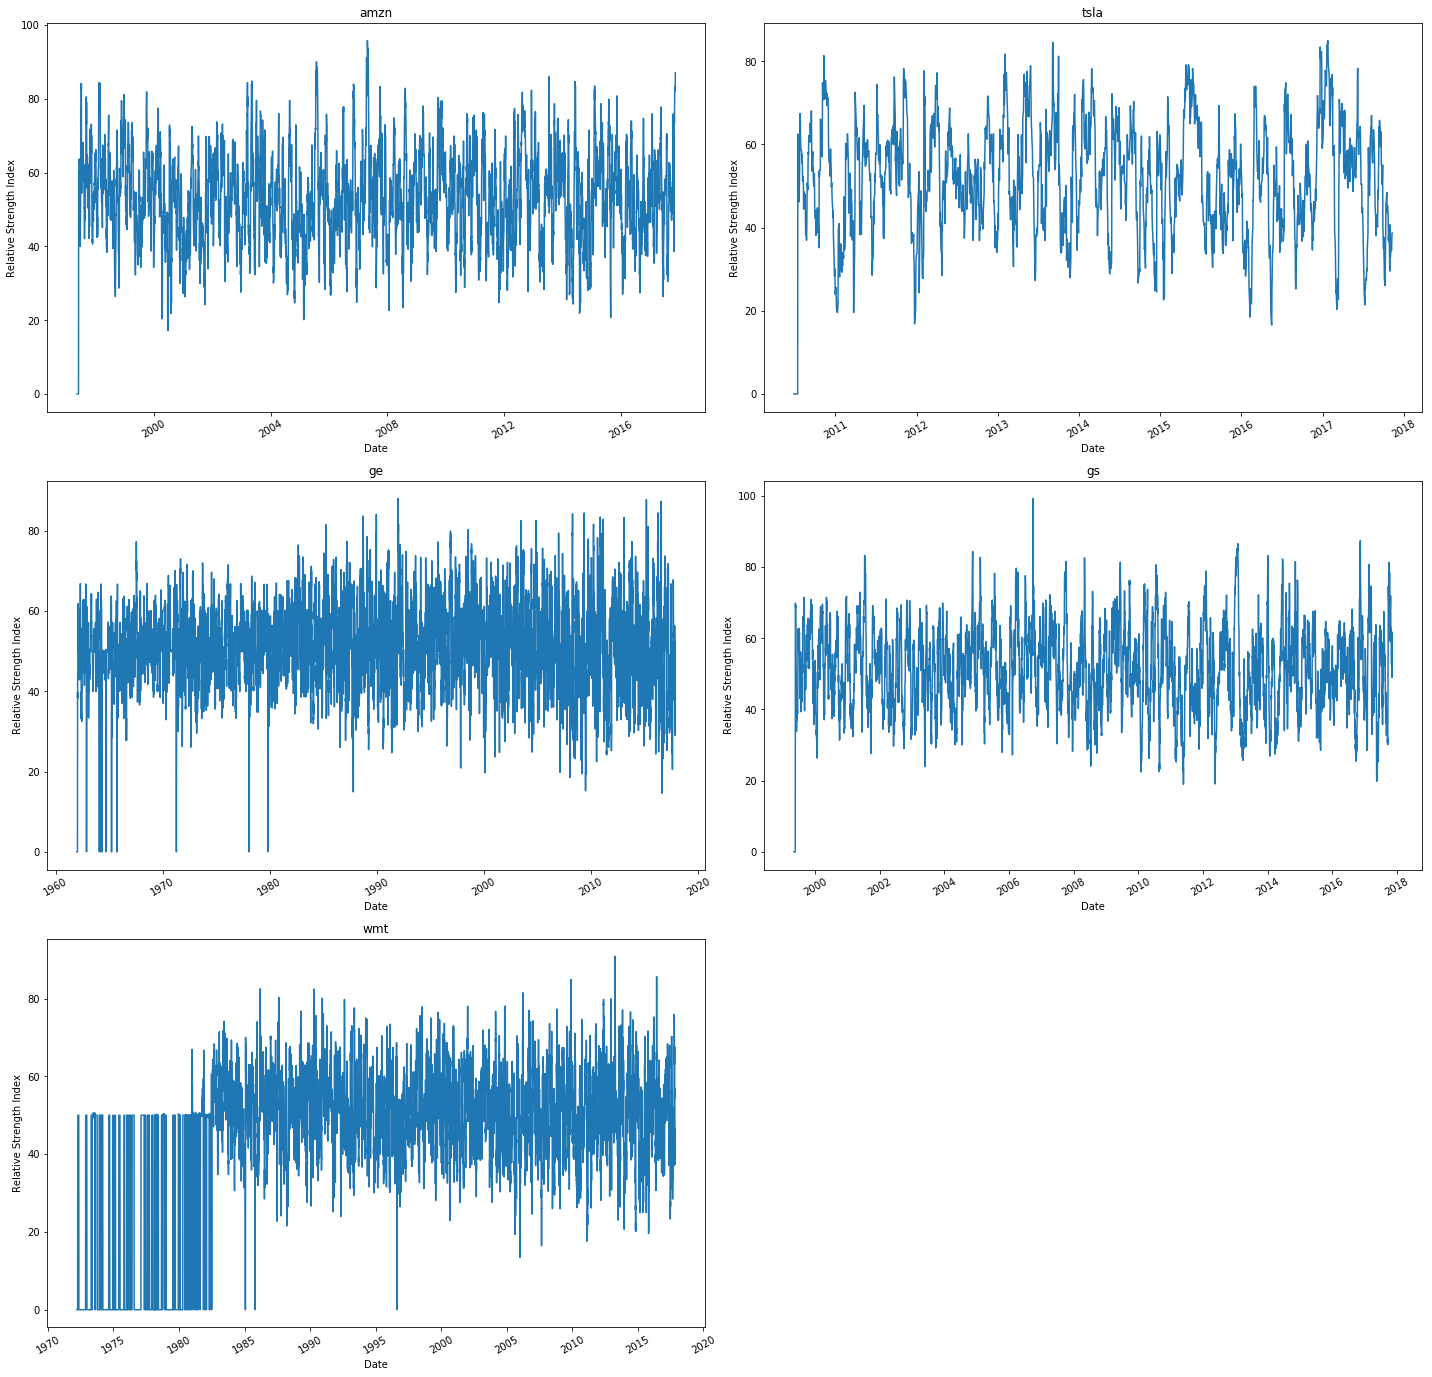

In [54]:
%matplotlib inline

# RSI Plot

fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['RSI_14D'])
    ax.set_title(str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Relative Strength Index")
    plt.xticks(rotation=30)
fig.tight_layout()


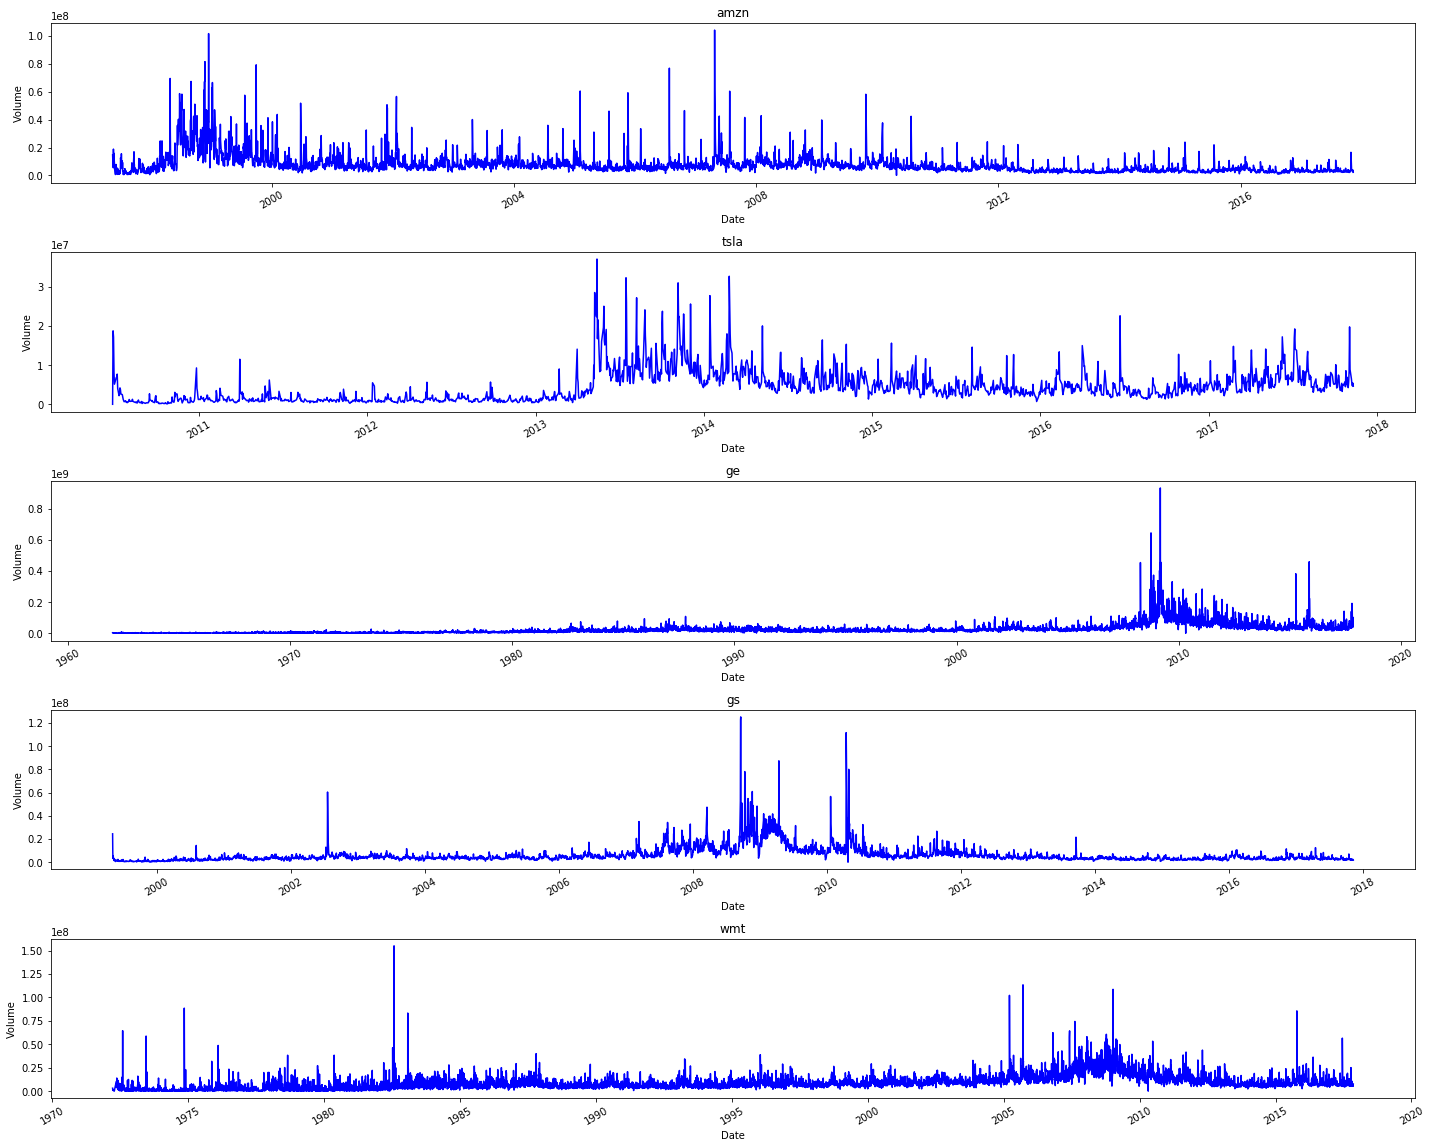

In [55]:
# Volume Plain plot
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(8,1,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Volume_plain'], 'b')
    ax.set_title(str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Volume")
    plt.xticks(rotation=30)
fig.tight_layout()

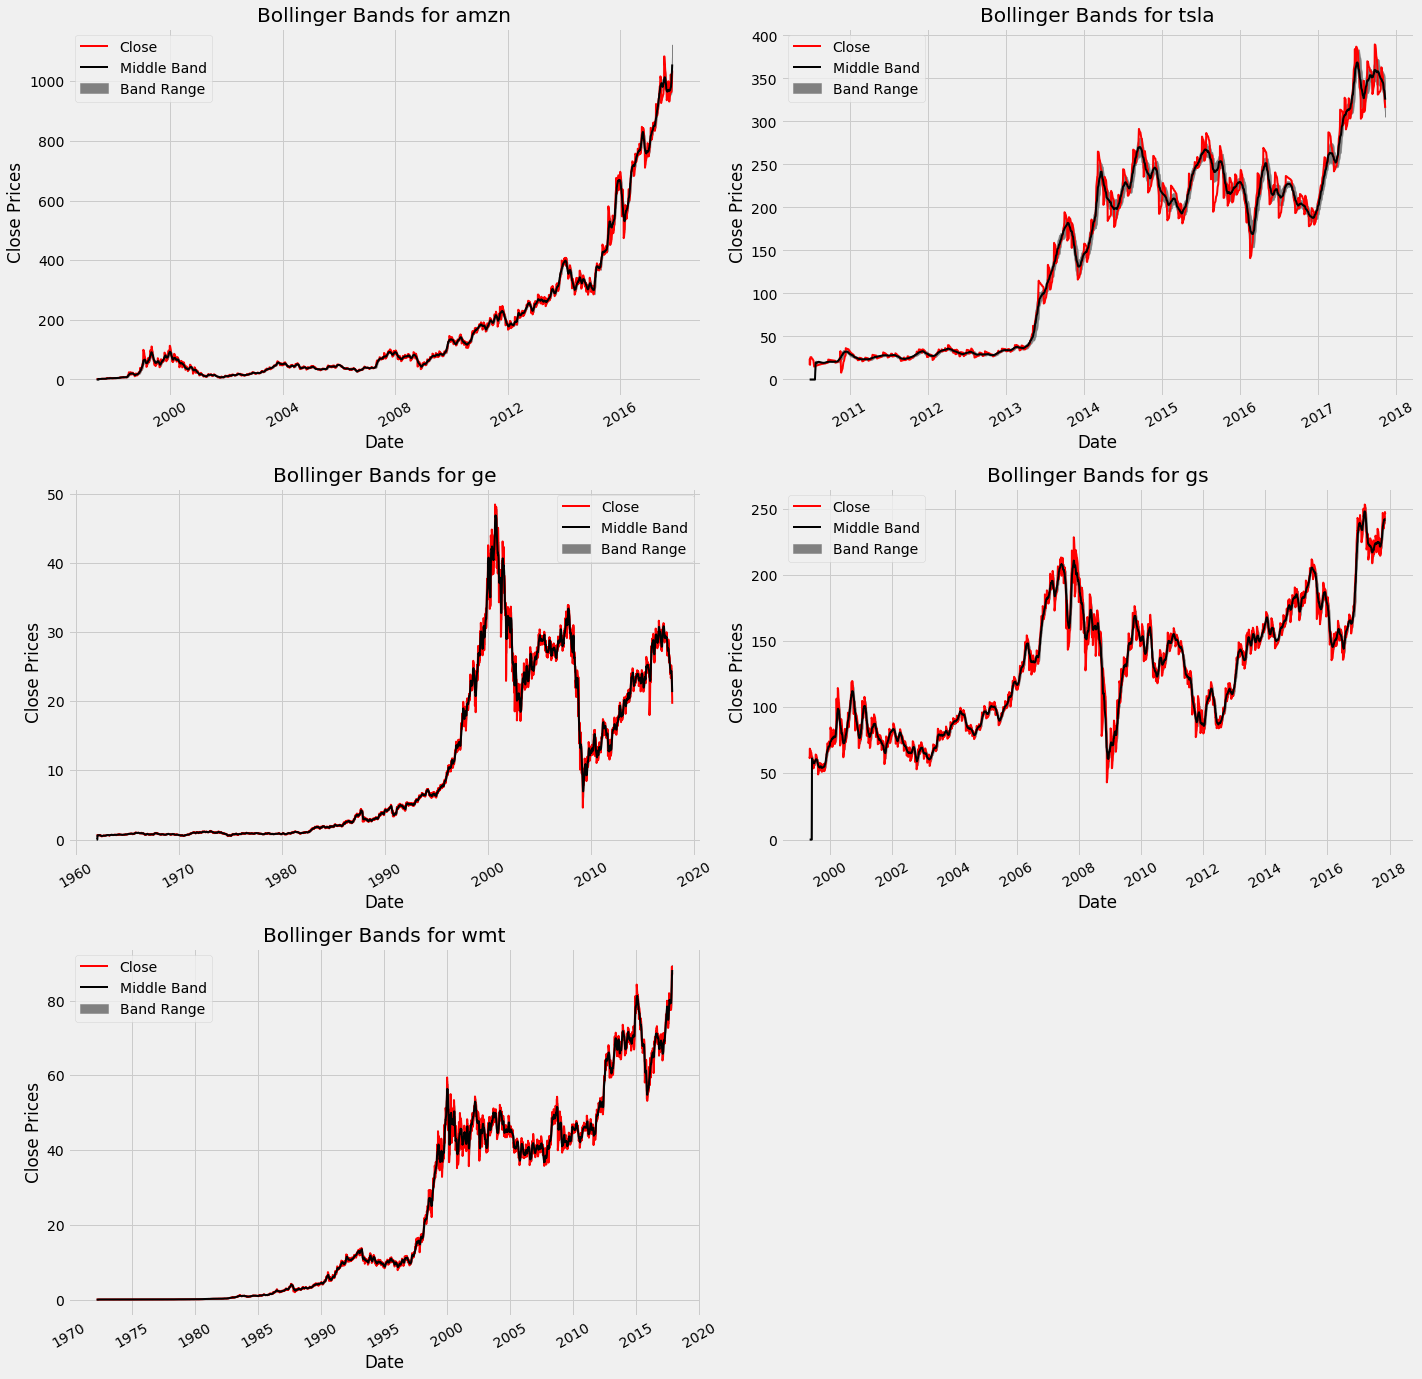

In [56]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.fill_between(TechIndicator[i].index, TechIndicator[i]['BB_Upper_Band'], TechIndicator[i]['BB_Lower_Band'], color='grey', label="Band Range")
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], color='red', lw=2, label="Close")
    ax.plot(TechIndicator[i].index, TechIndicator[i]['BB_Middle_Band'], color='black', lw=2, label="Middle Band")
    ax.set_title("Bollinger Bands for " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()
#.dt.to_pydatetime()

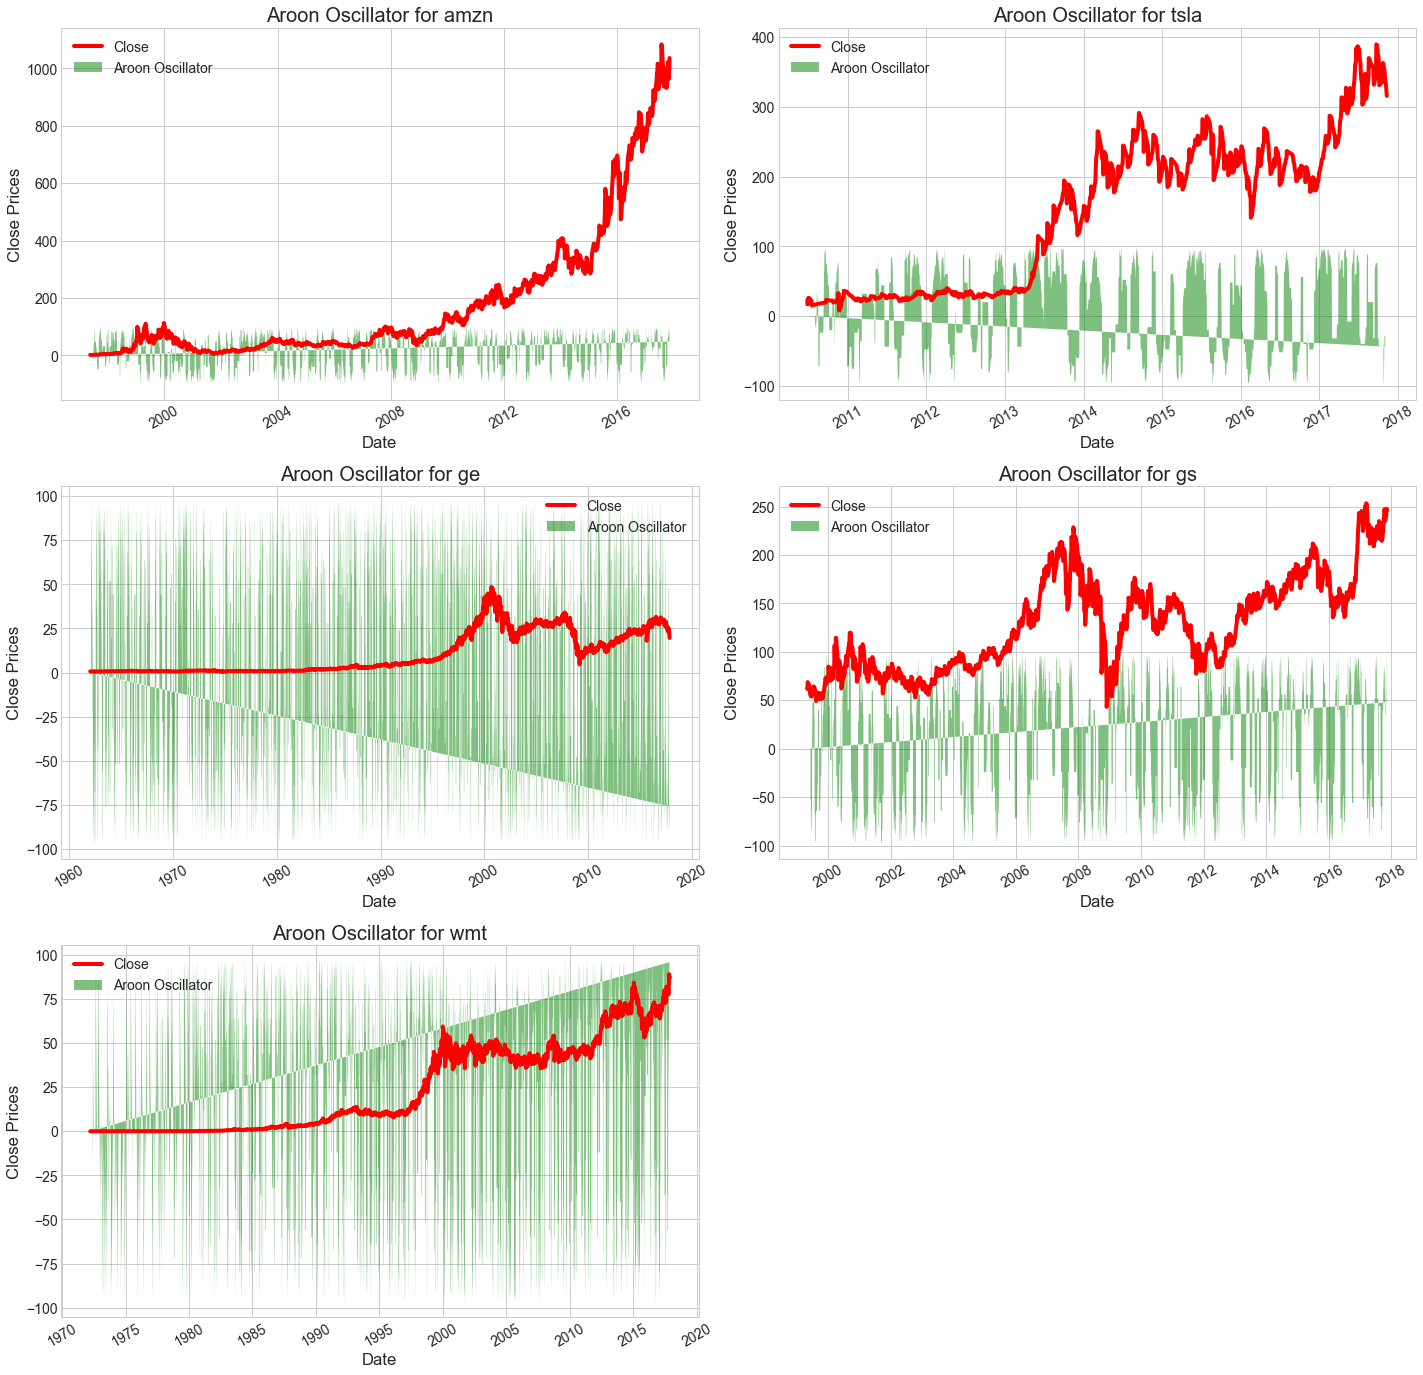

In [57]:
# Aroon Oscillator Plot
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.fill(TechIndicator[i].index, TechIndicator[i]['Aroon_Oscillator'],'g', alpha = 0.5, label = "Aroon Oscillator")
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], 'r', label="Close")
    ax.set_title("Aroon Oscillator for " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

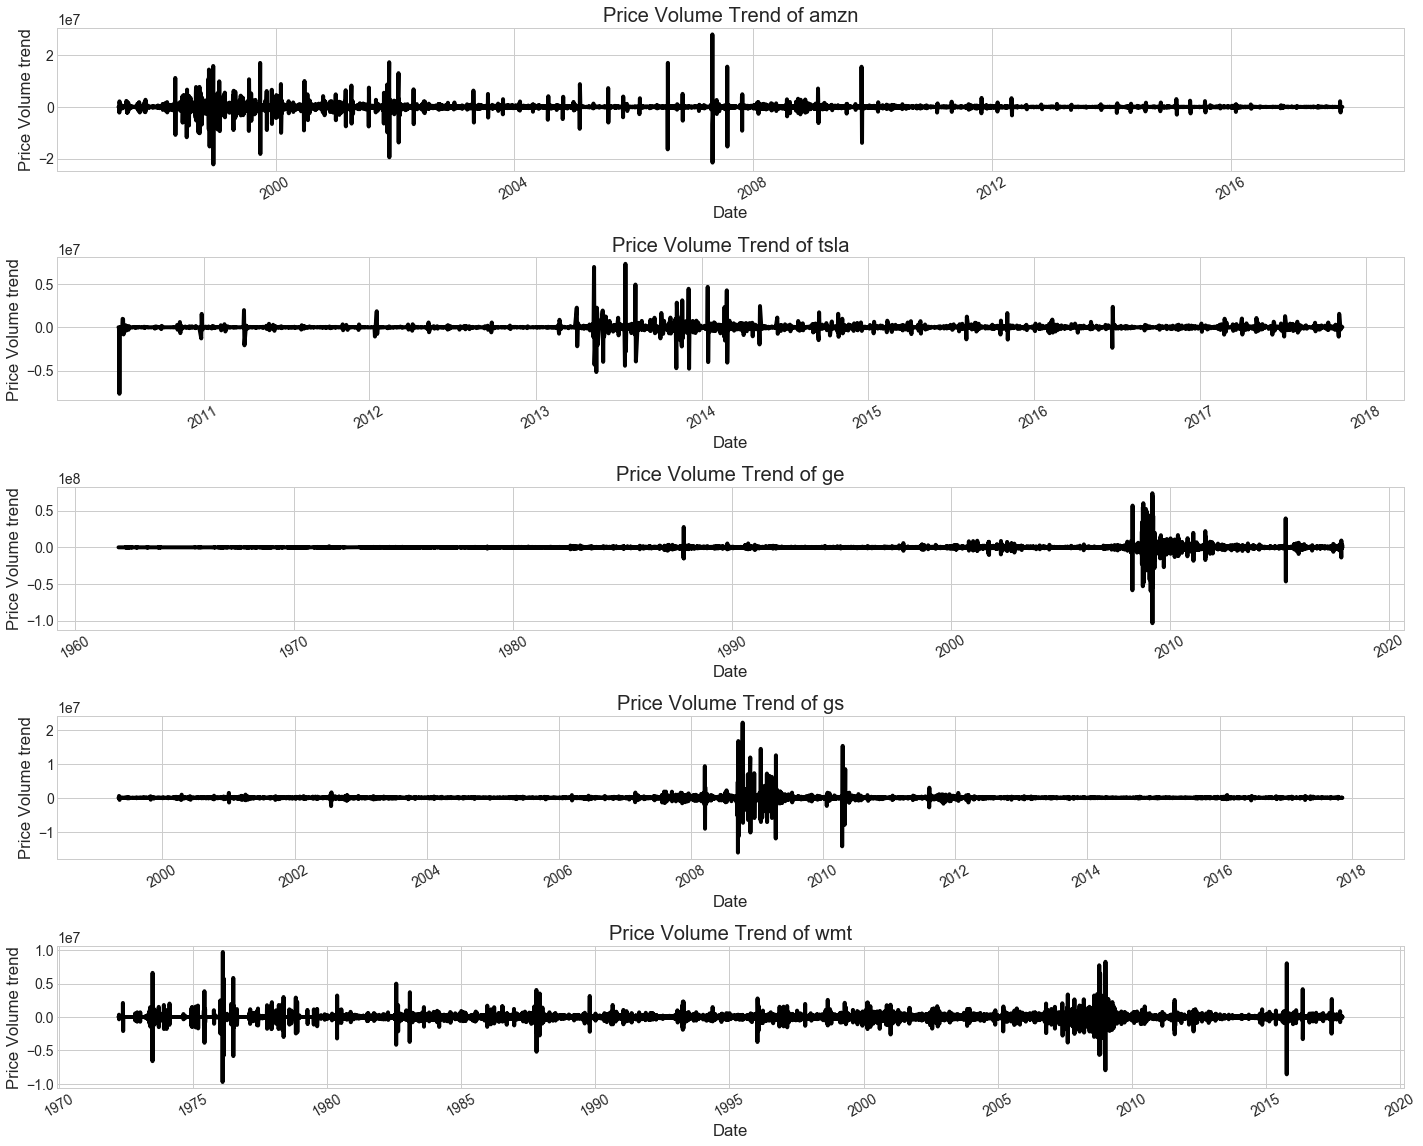

In [58]:
# PRice Volume Trend Plot
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(8,1,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['PVT'], 'black')
    ax.set_title("Price Volume Trend of " +str(TechIndicator[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price Volume trend")
    plt.xticks(rotation=30)
fig.tight_layout()

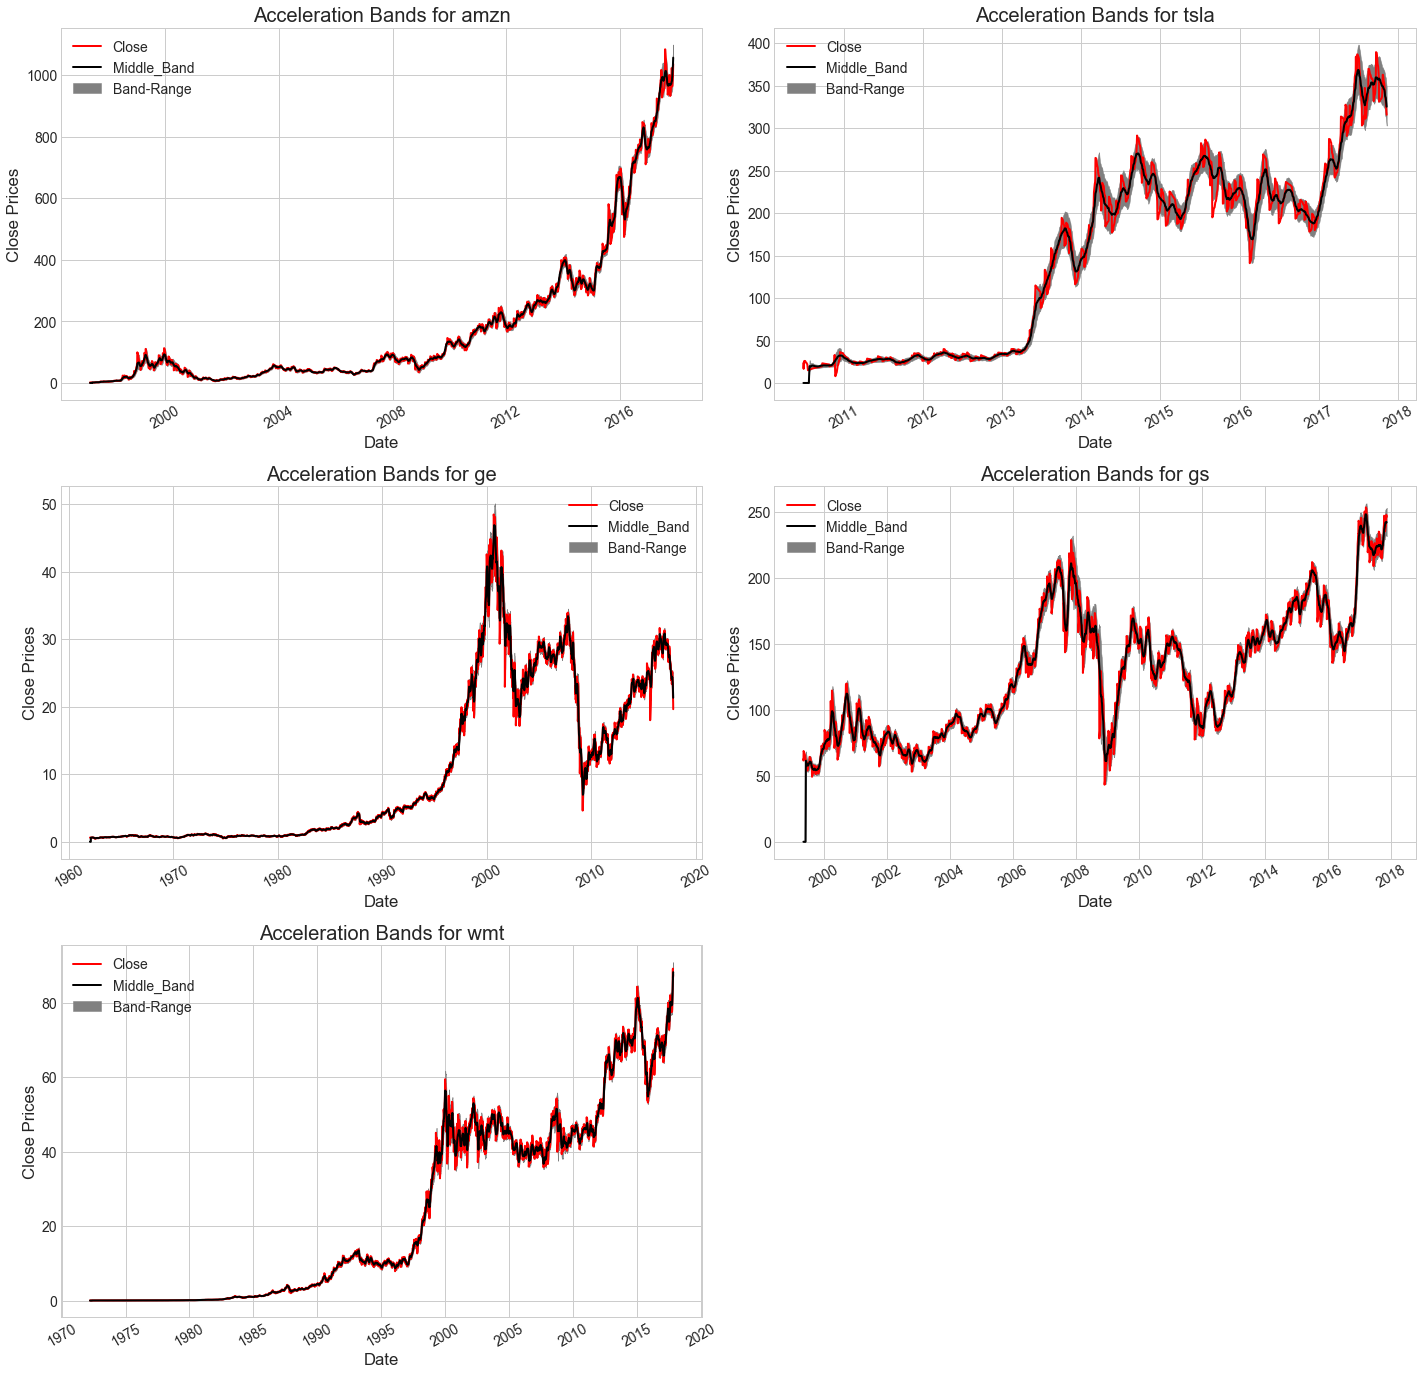

In [59]:
# Acceleration band Plot

fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.fill_between(TechIndicator[i].index, TechIndicator[i]['AB_Upper_Band'], TechIndicator[i]['AB_Lower_Band'], color='grey', label = "Band-Range")
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], color='red', lw=2, label = "Close")
    ax.plot(TechIndicator[i].index, TechIndicator[i]['AB_Middle_Band'], color='black', lw=2, label="Middle_Band")
    ax.set_title("Acceleration Bands for " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

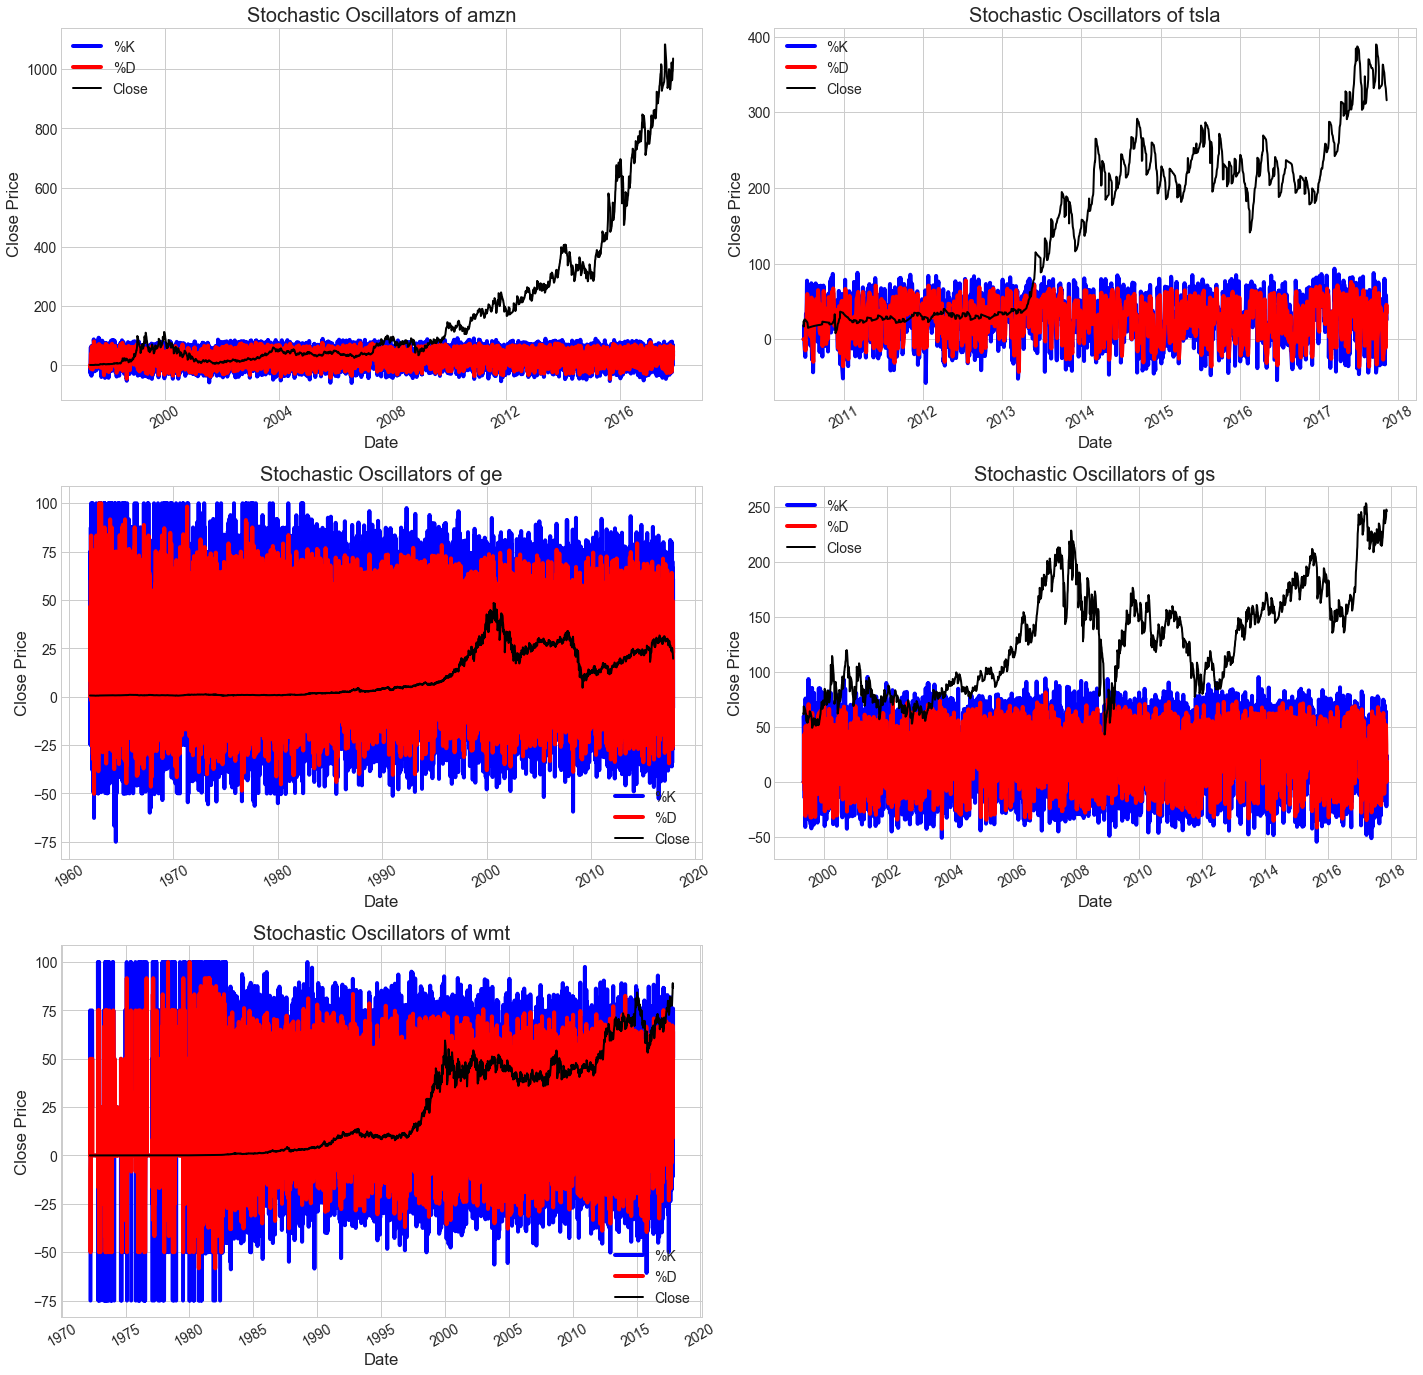

In [60]:
# Stochastic Oscillator plots
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['STOK'], 'blue', label="%K")
    ax.plot(TechIndicator[i].index, TechIndicator[i]['STOD'], 'red', label="%D")
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], color='black', lw=2, label = "Close")
    ax.set_title("Stochastic Oscillators of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


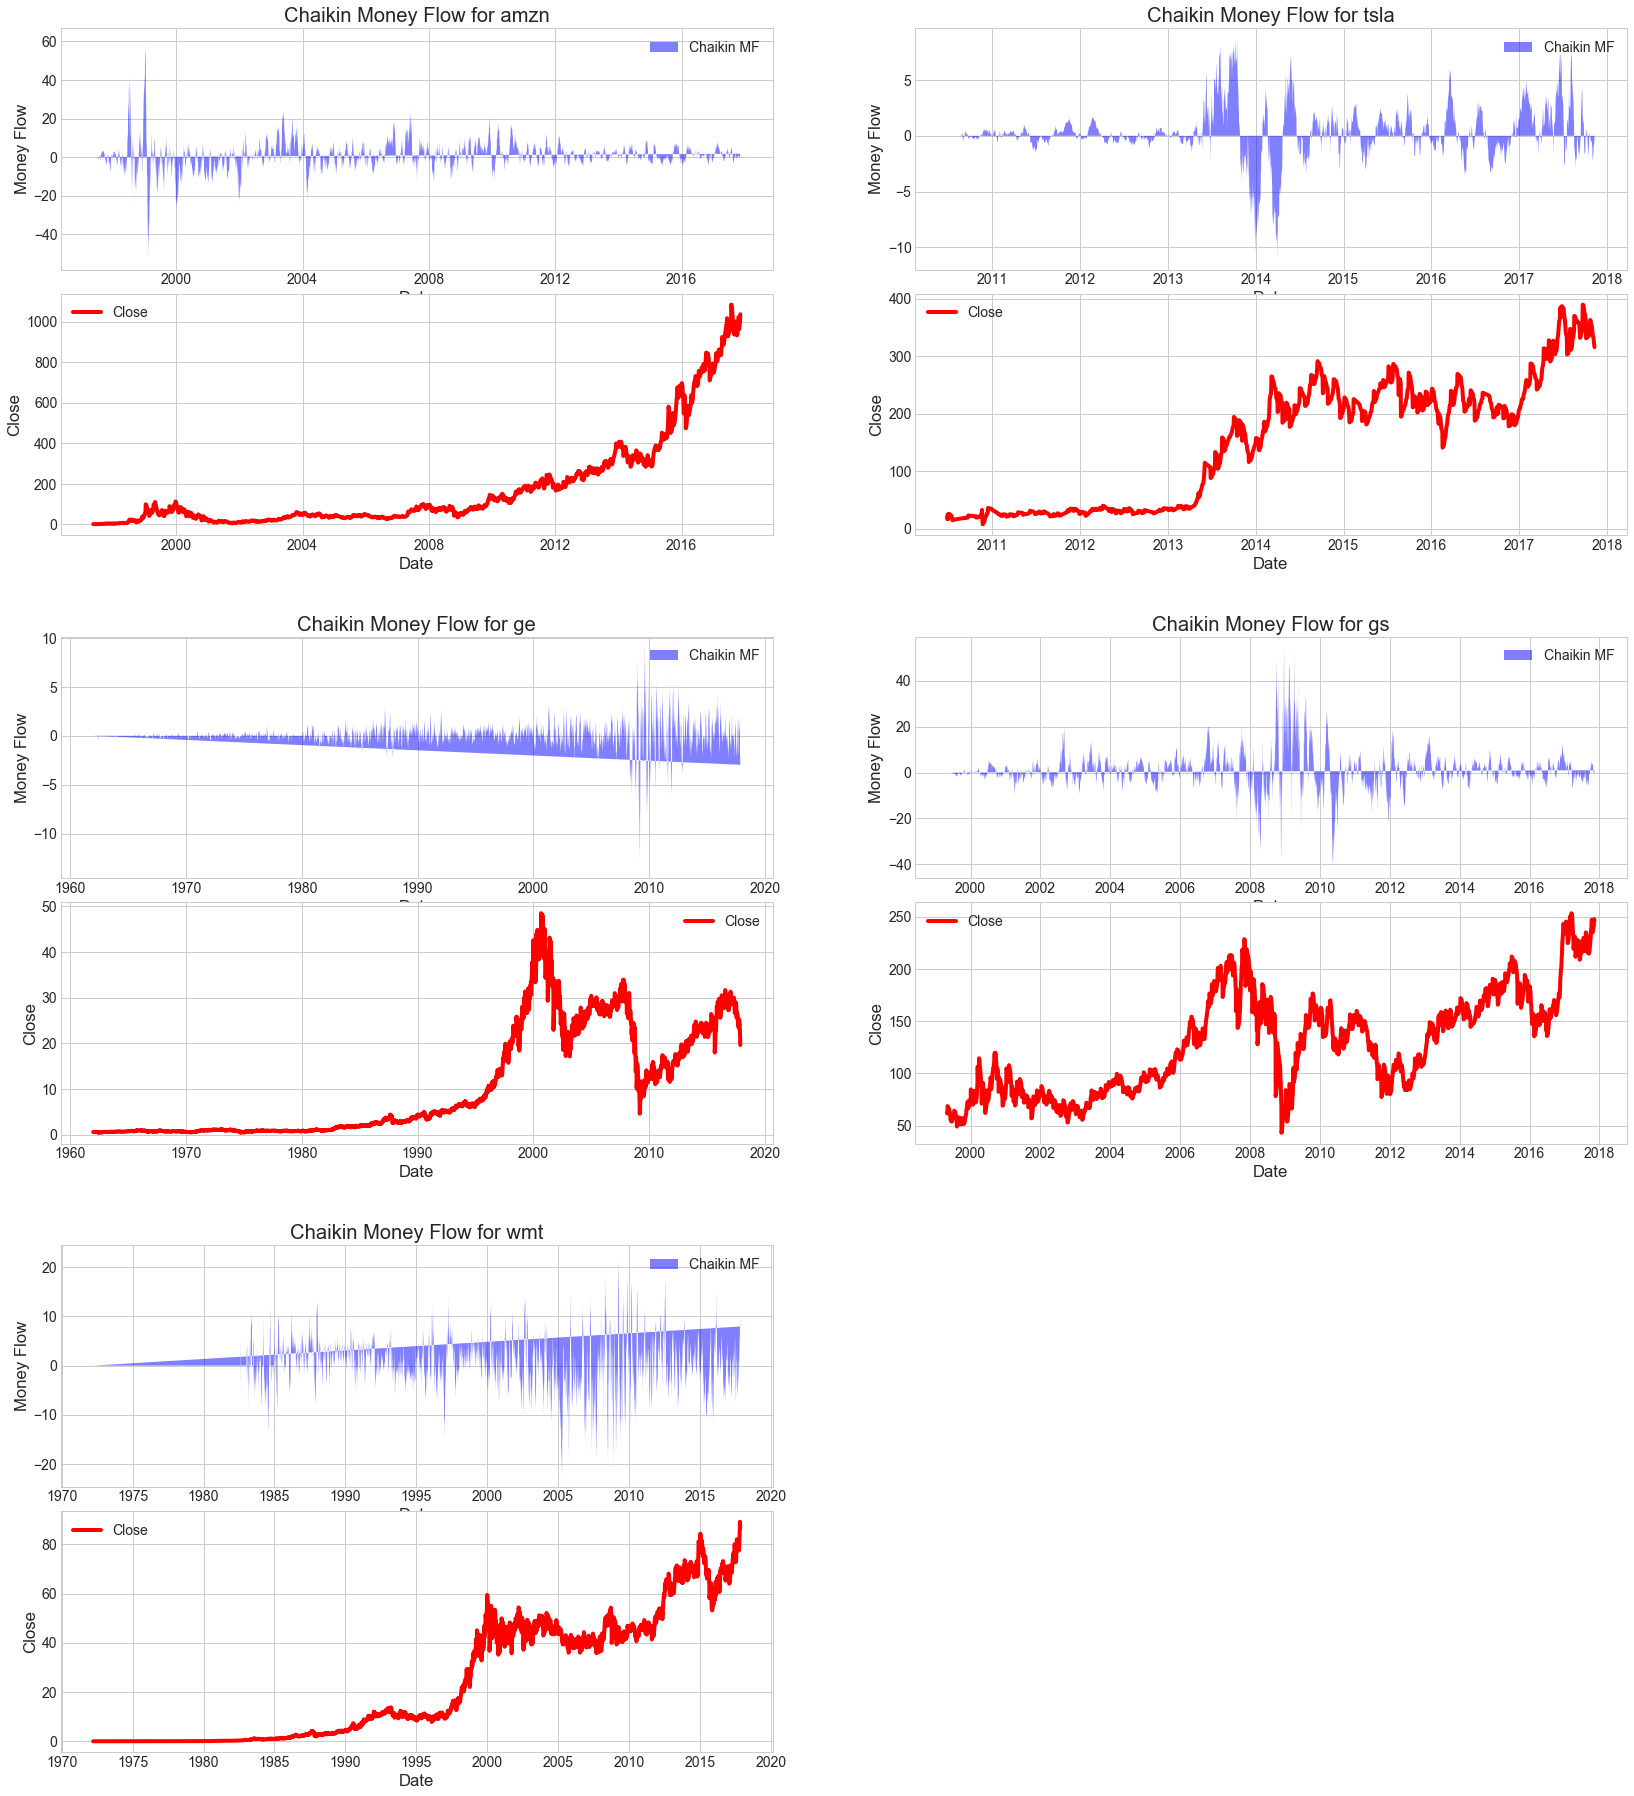

In [61]:
# Chaikin Money Flow Plots
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25,40))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for i in range(5):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            t = ax.fill(TechIndicator[i].index, TechIndicator[i]['Chaikin_MF'],'b', alpha = 0.5, label = "Chaikin MF")
            ax.set_title("Chaikin Money Flow for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("Money Flow")
        else:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], 'r', label="Close")
            t = ax.set_ylabel("Close")
        ax.legend()
        ax.set_xlabel("Date")
        
        fig.add_subplot(ax)
fig.tight_layout()

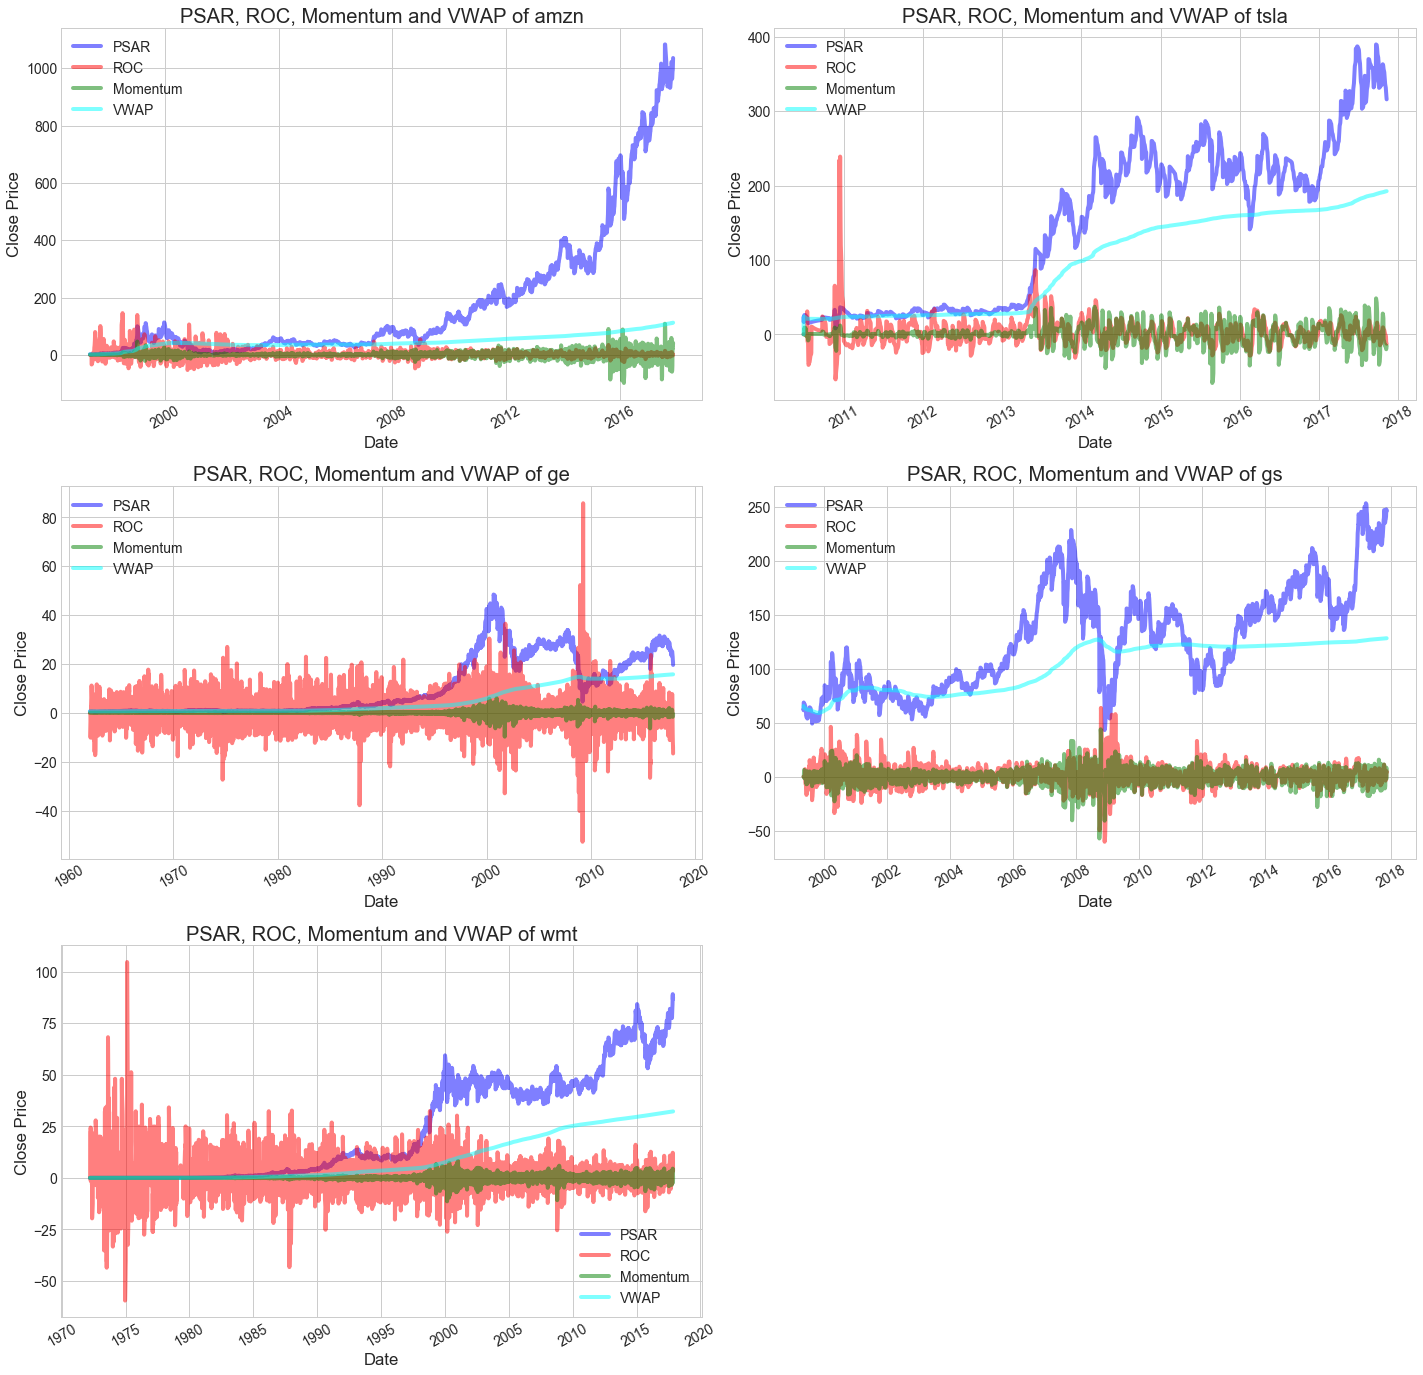

In [62]:
# Parabolic SAR, Rate of Change, Momentum and VWAP Plots
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['psar'], 'blue', label="PSAR", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['ROC'], 'red', label="ROC", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Momentum'], 'green', label="Momentum", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['VWAP'], 'cyan', label="VWAP", alpha = 0.5)
    ax.set_title("PSAR, ROC, Momentum and VWAP of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()

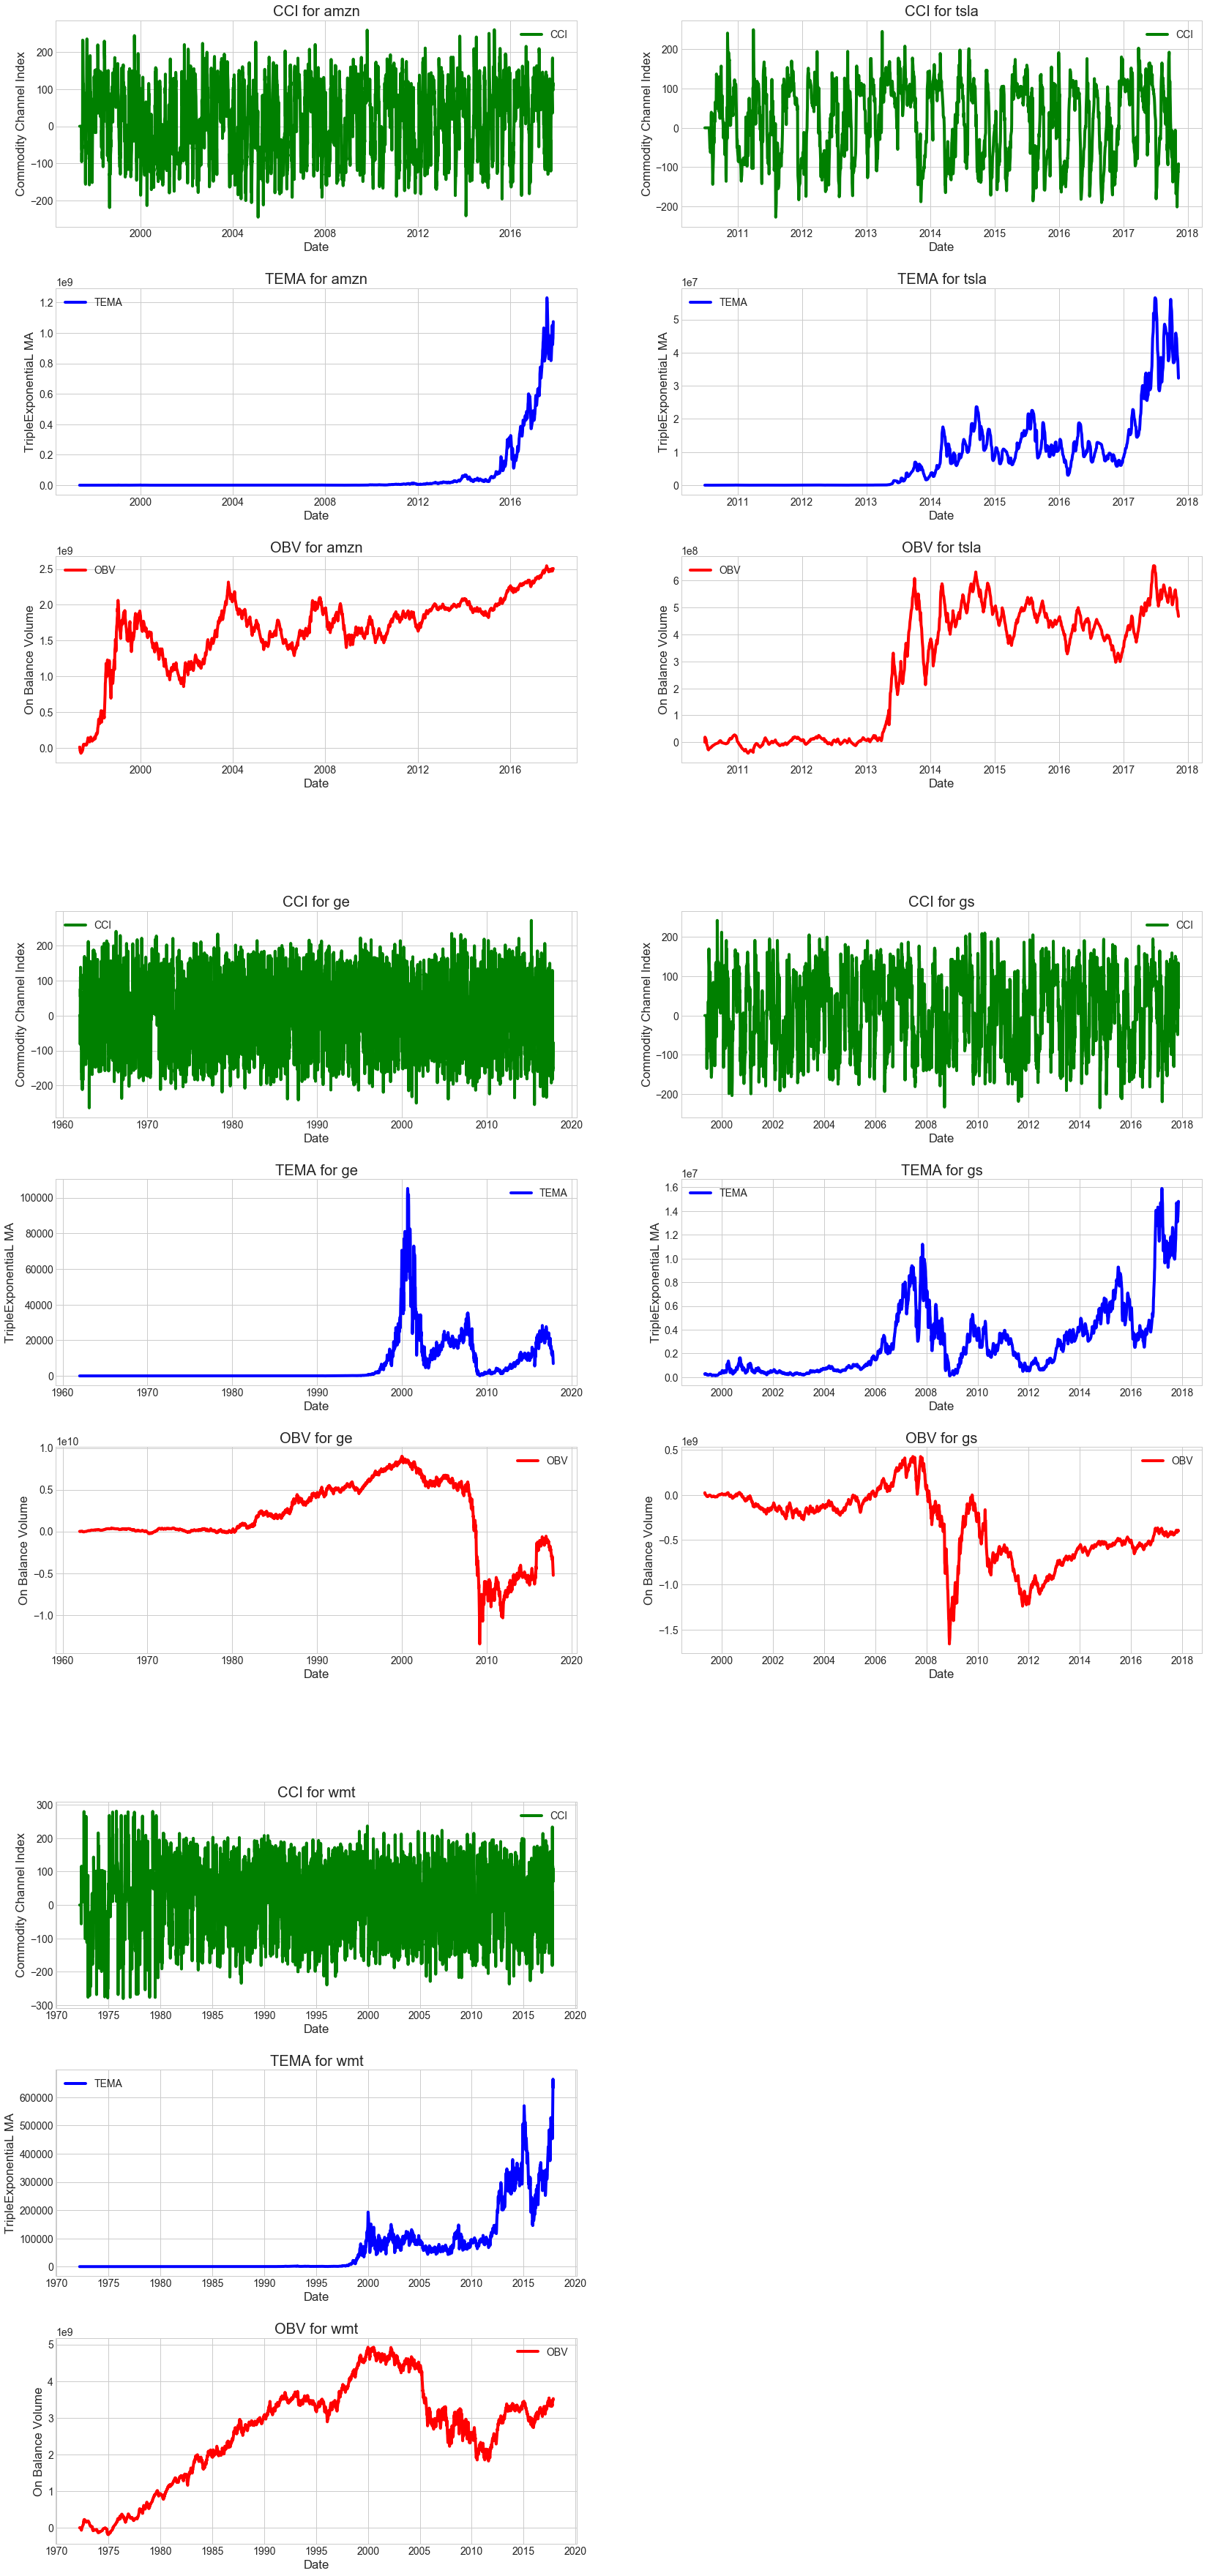

In [63]:
# Commodity Channel Index, Triple Exponential Moving Average On Banalance Volume Plots

fig = plt.figure(figsize=(25,80))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for i in range(5):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.3, hspace=0.3)

    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['CCI'], 'green', label="CCI")
            t = ax.set_title("CCI for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("Commodity Channel Index")
        elif j == 1:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['TEMA'], 'blue', label="TEMA")
            t = ax.set_title("TEMA for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("TripleExponentiaL MA")
        else:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['OBV'], 'red', label="OBV")
            t = ax.set_title("OBV for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("On Balance Volume")
        ax.legend()
        #ax.set_title("CCI, TEMA, OBV for " +str(techindi2[i]['Label'][0]))
        ax.set_xlabel("Date")
        
        fig.add_subplot(ax)
fig.tight_layout()

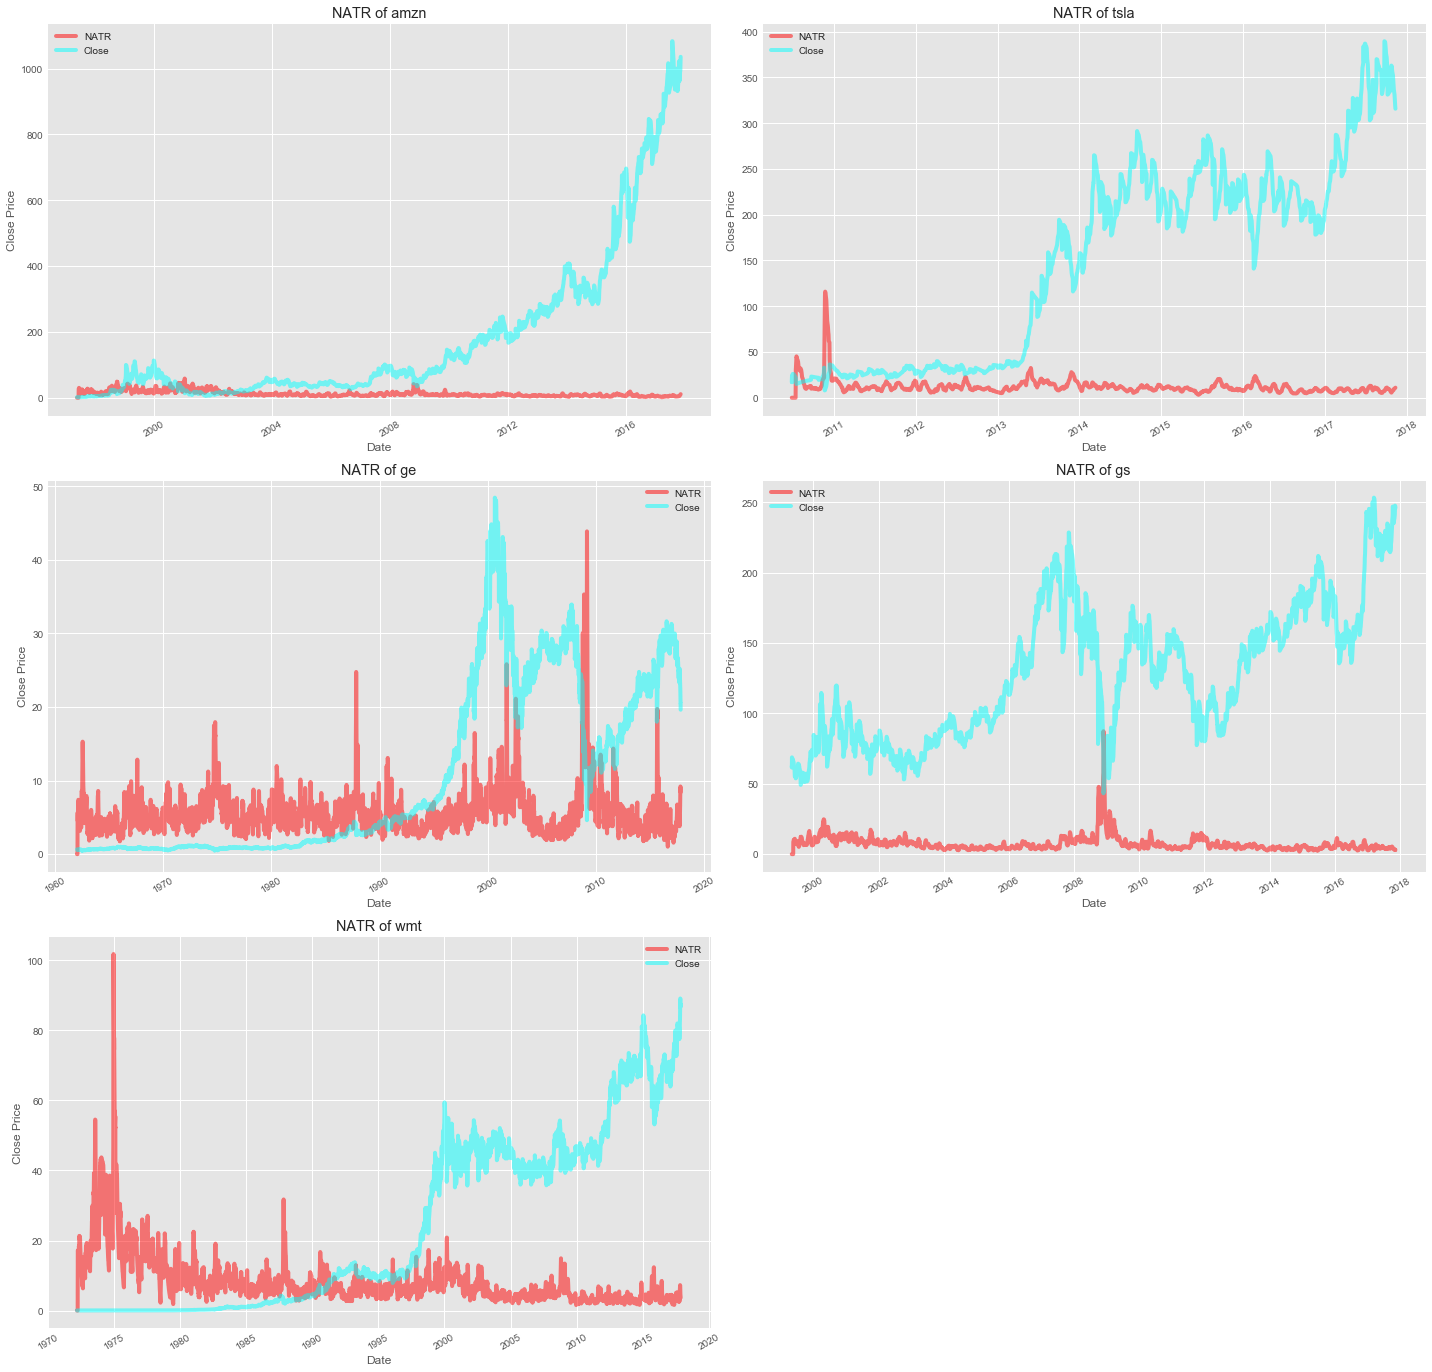

In [64]:
# Normalized Average True range Plots
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['NATR'], 'red', label="NATR", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], 'cyan', label="Close", alpha = 0.5)
    ax.set_title("NATR of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()

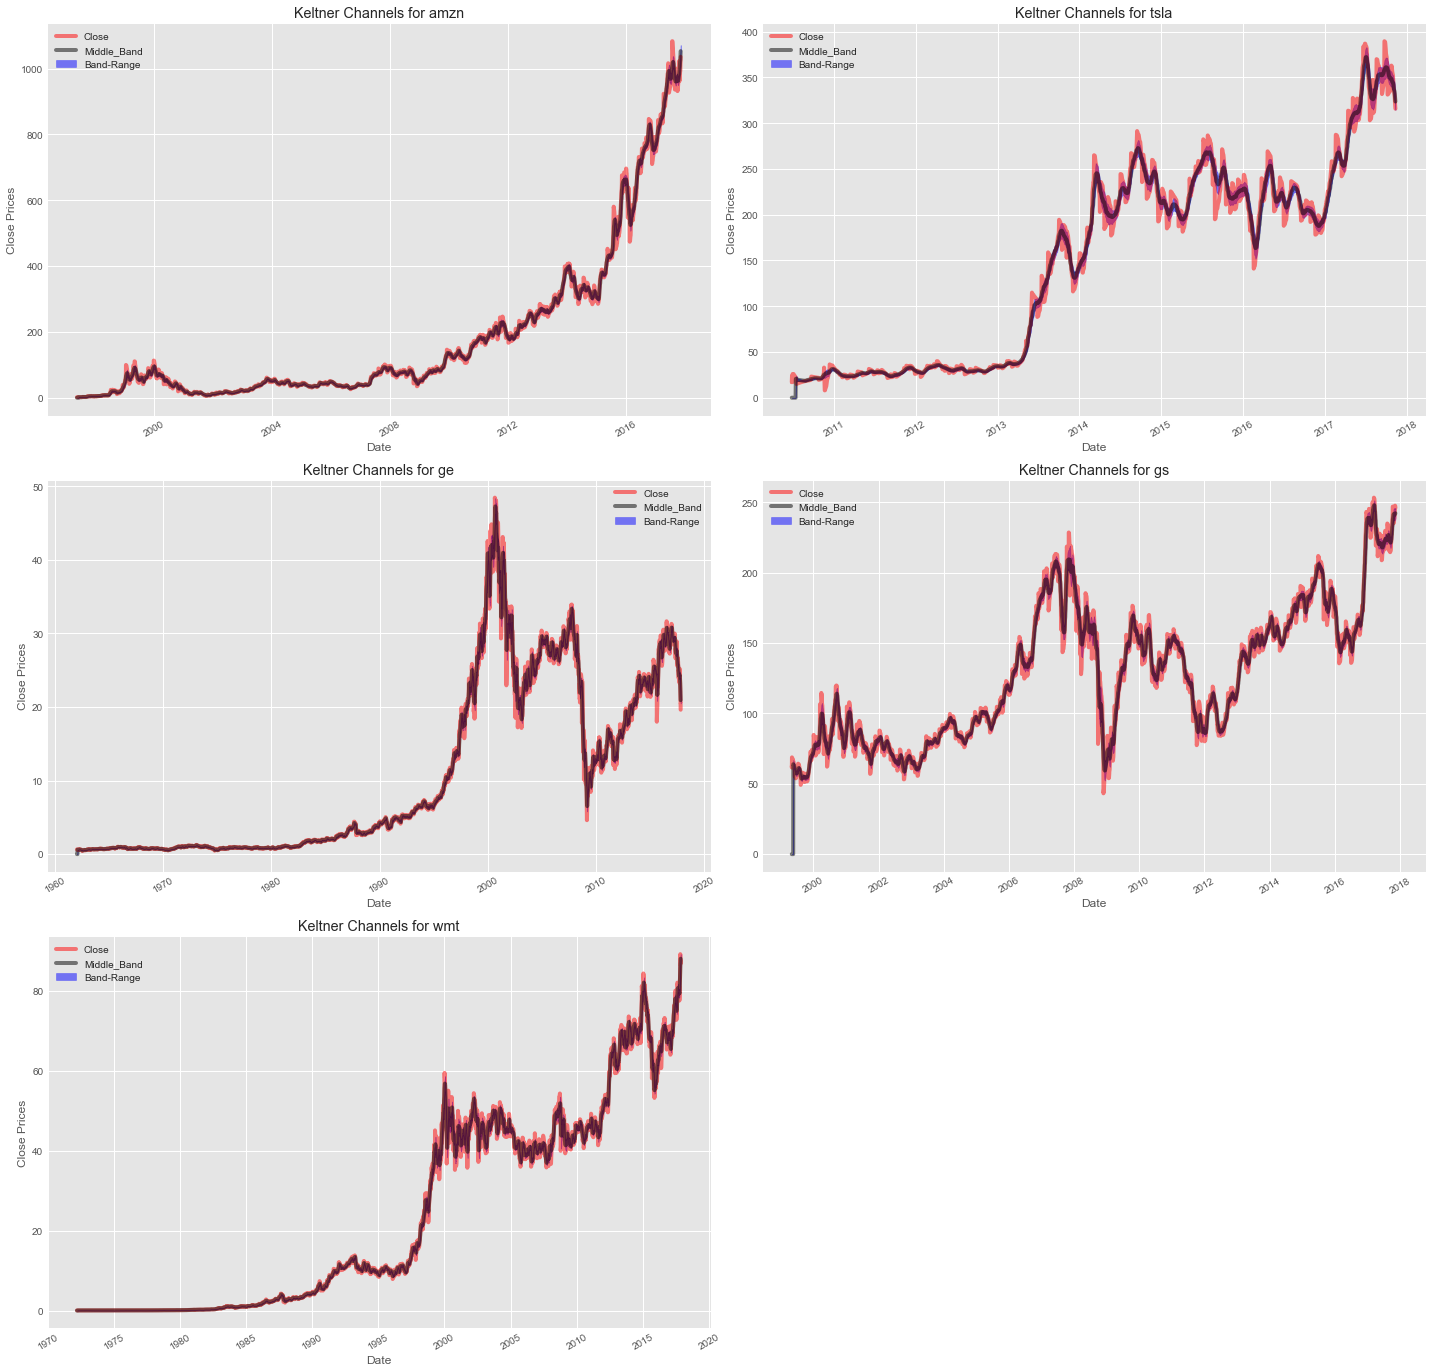

In [65]:
# Keltner Channels Plots

fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.fill_between(TechIndicator[i].index, TechIndicator[i]['Kelch_Upper'], TechIndicator[i]['Kelch_Down'], 
                    color='blue', label = "Band-Range", alpha = 0.5)
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], color='red', label = "Close", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Kelch_Middle'], color='black', label="Middle_Band", alpha = 0.5)
    ax.set_title("Keltner Channels for " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

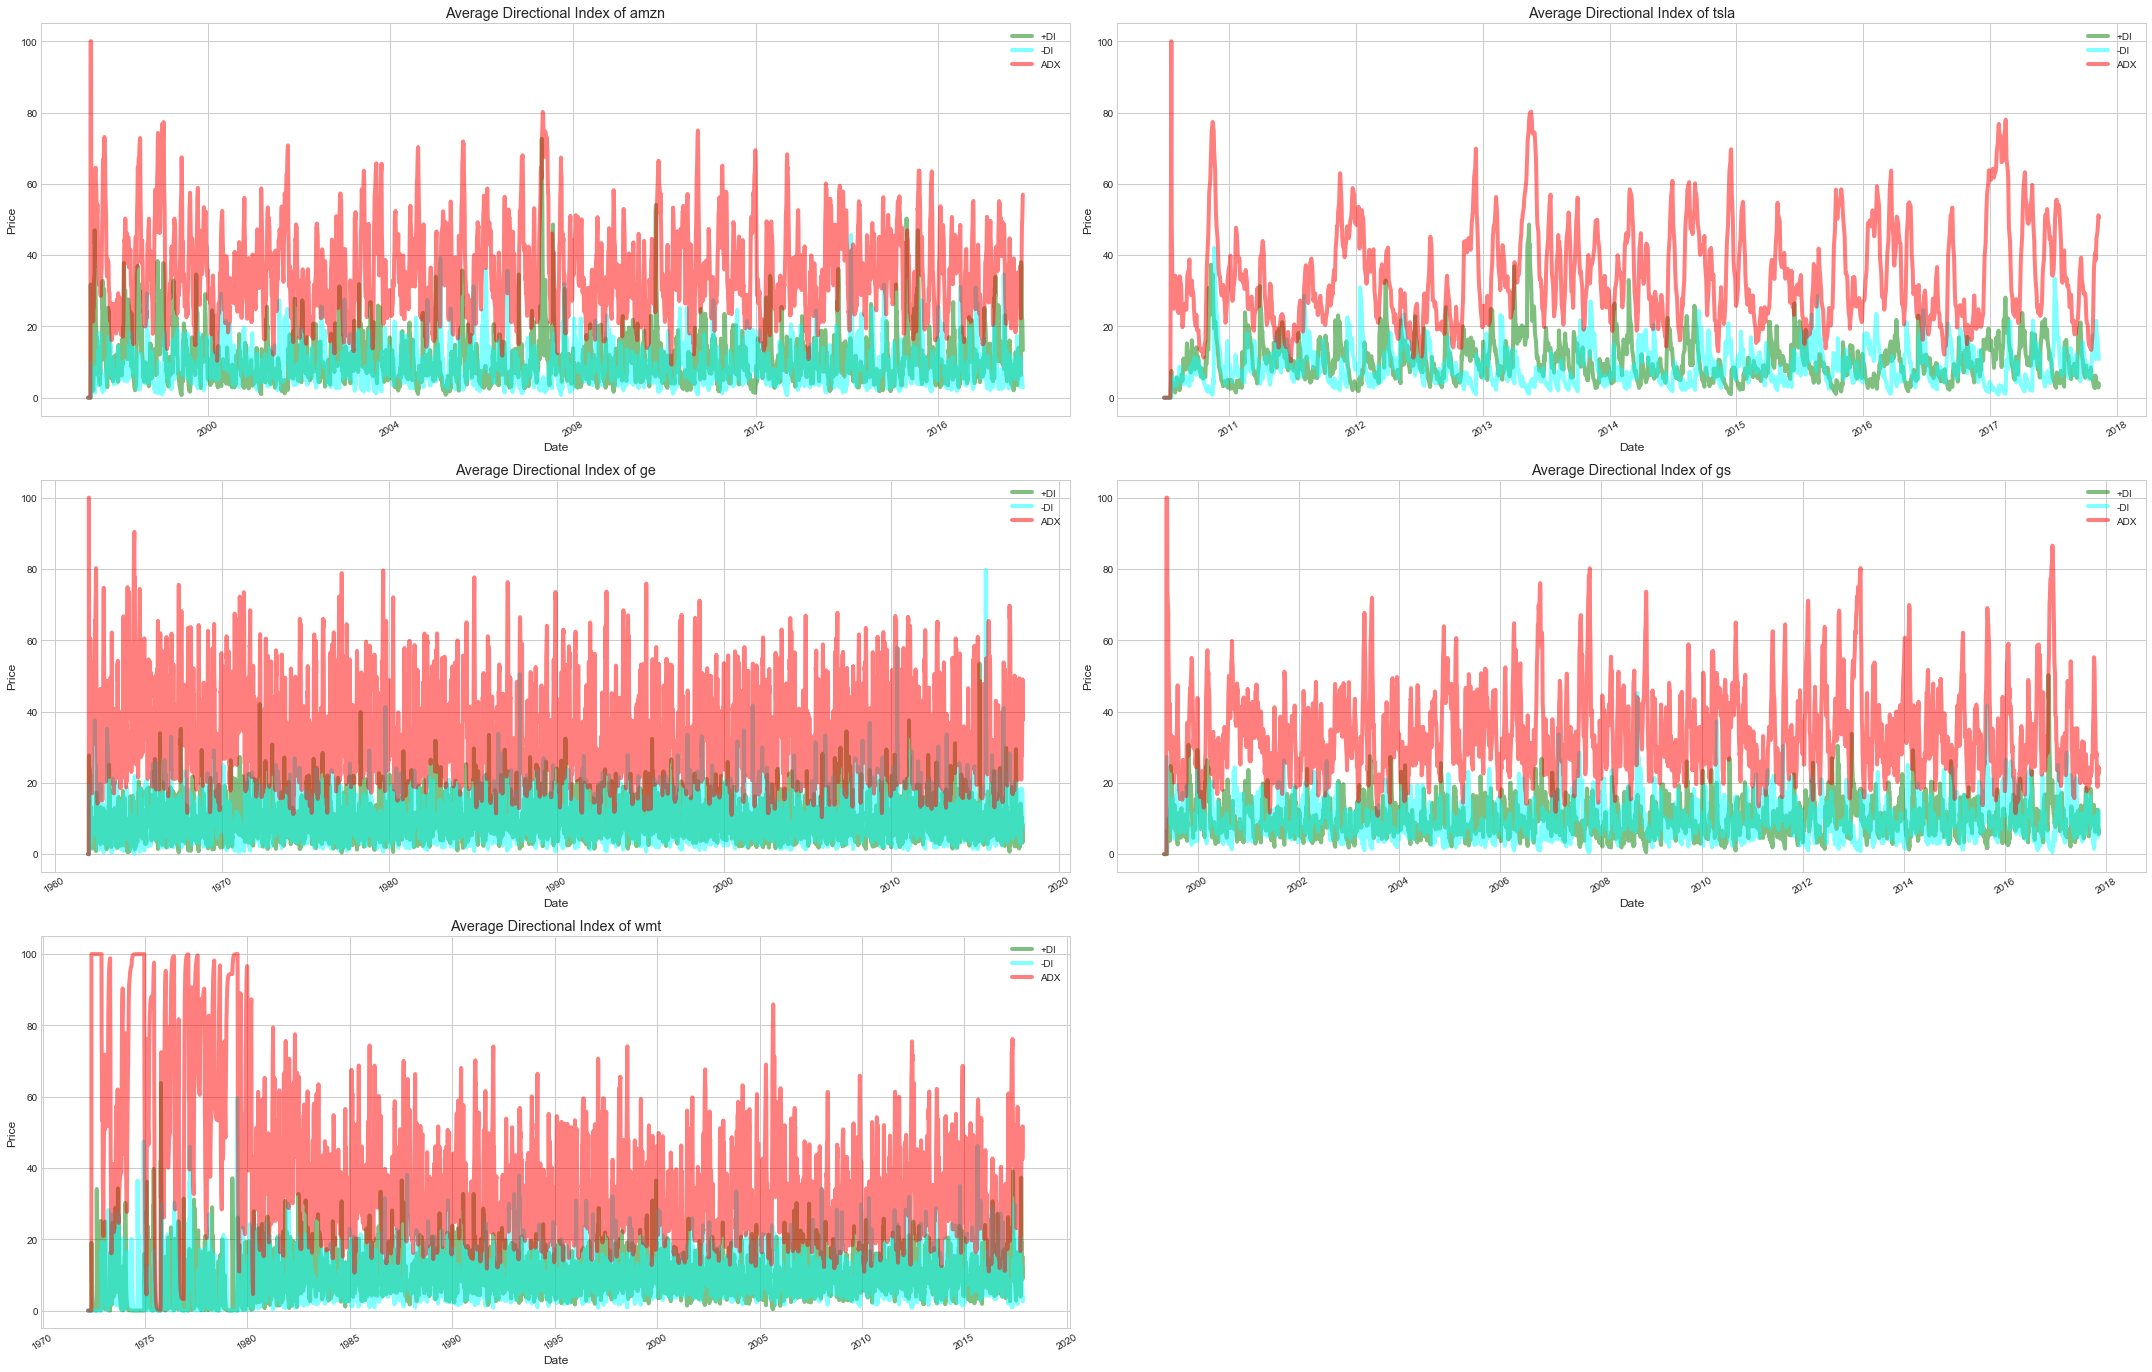

In [66]:
# Average Directional Index
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['plusDI'], 'green', label="+DI", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['minusDI'], 'cyan', label="-DI", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['ADX'], 'red', label="ADX", alpha = 0.5)
    ax.set_title("Average Directional Index of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.xticks(rotation=30)
fig.tight_layout()

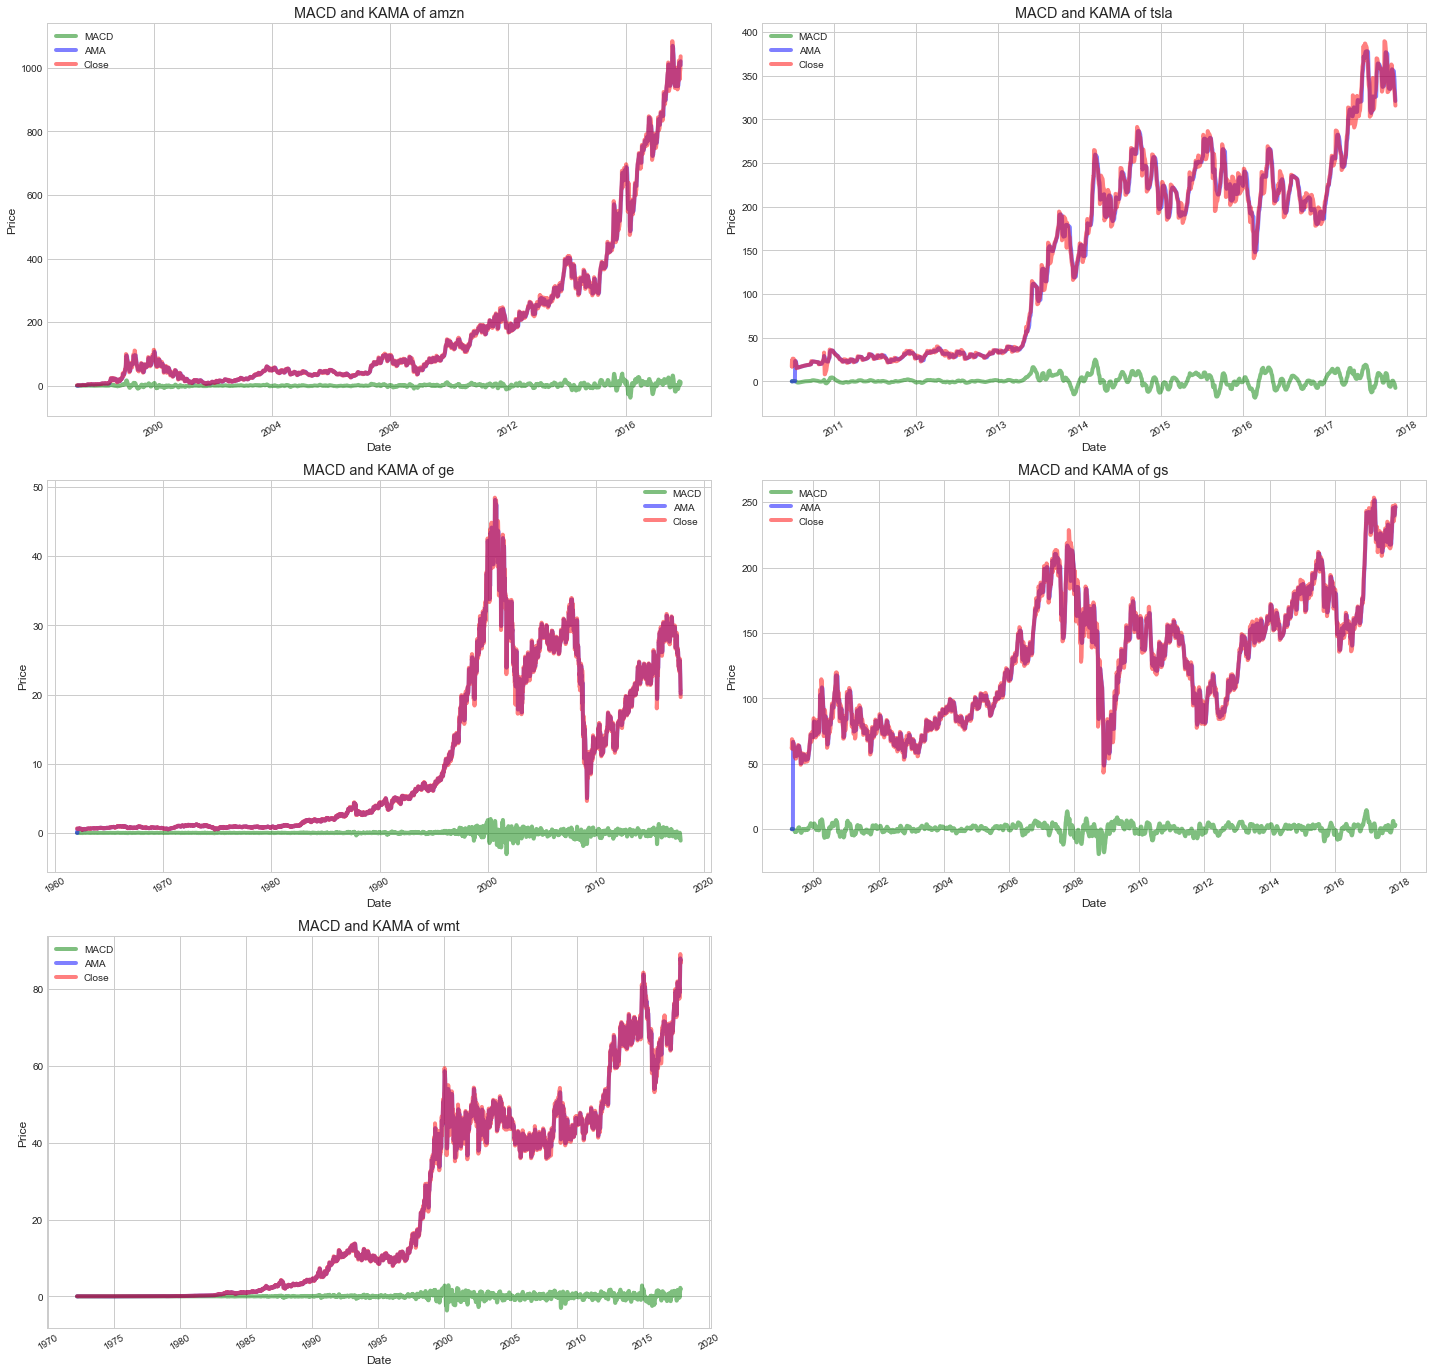

In [67]:
# Moving Average Convergence Divergence, Adaptive Moving Avergae Plots
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['MACD'], 'green', label="MACD", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['KAMA'], 'blue', label="AMA", alpha = 0.5)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['Close'], 'red', label="Close", alpha = 0.5)
    ax.set_title("MACD and KAMA of " +str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.xticks(rotation=30)
fig.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


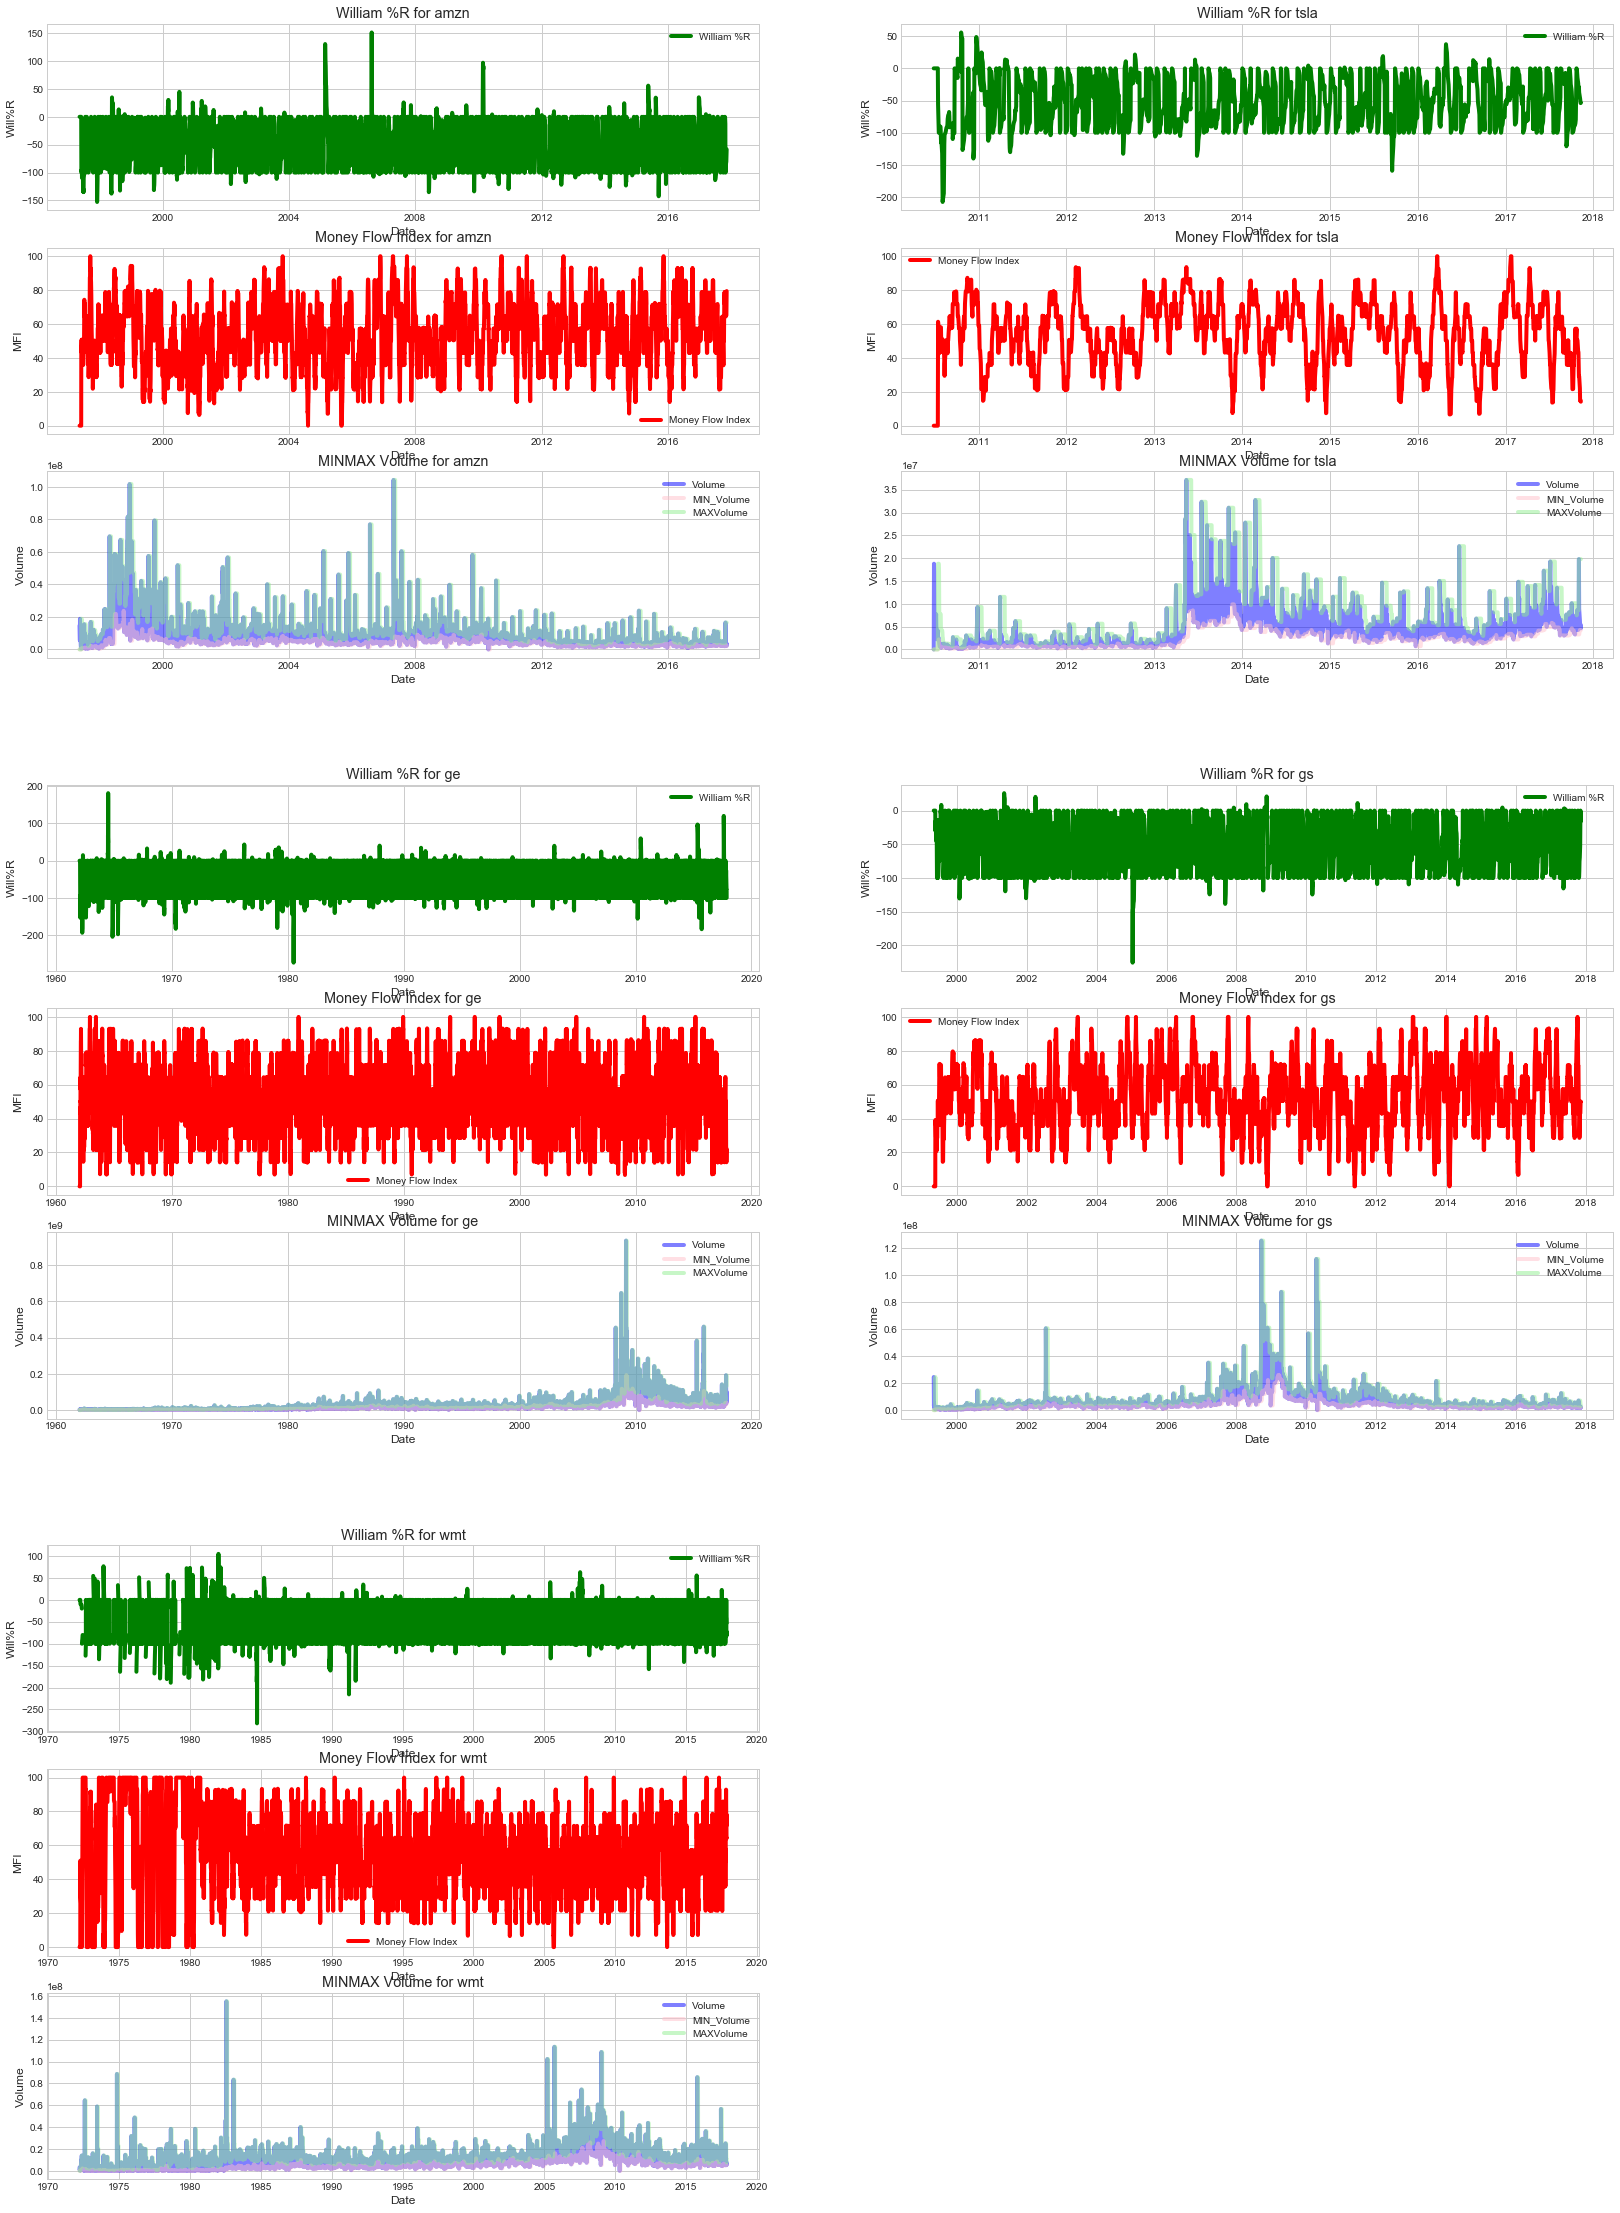

In [68]:
# William %R, Money Flow
fig = plt.figure(figsize=(25,50))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for i in range(5):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.2)

    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['WillR'], 'green', label="William %R")
            t = ax.set_title("William %R for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("Will%R")
        elif j ==1:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['Money_Flow_Index'], 'red', label="Money Flow Index")
            
            t = ax.set_title("Money Flow Index for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("MFI")
        else:
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['Volume'], 'blue', label="Volume", alpha = 0.5)
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['MIN_Volume'], 'pink', label="MIN_Volume", alpha = 0.5)
            t = ax.plot(TechIndicator[i].index, TechIndicator[i]['MAX_Volume'], 'lightgreen', label="MAXVolume",  alpha = 0.5)
            t = ax.set_title("MINMAX Volume for " +str(TechIndicator[i]['Label'][0]))
            t = ax.set_ylabel("Volume")
        ax.legend()
        #ax.set_title("CCI, TEMA, OBV for " +str(techindi2[i]['Label'][0]))
        ax.set_xlabel("Date")
        
        fig.add_subplot(ax)
fig.tight_layout()

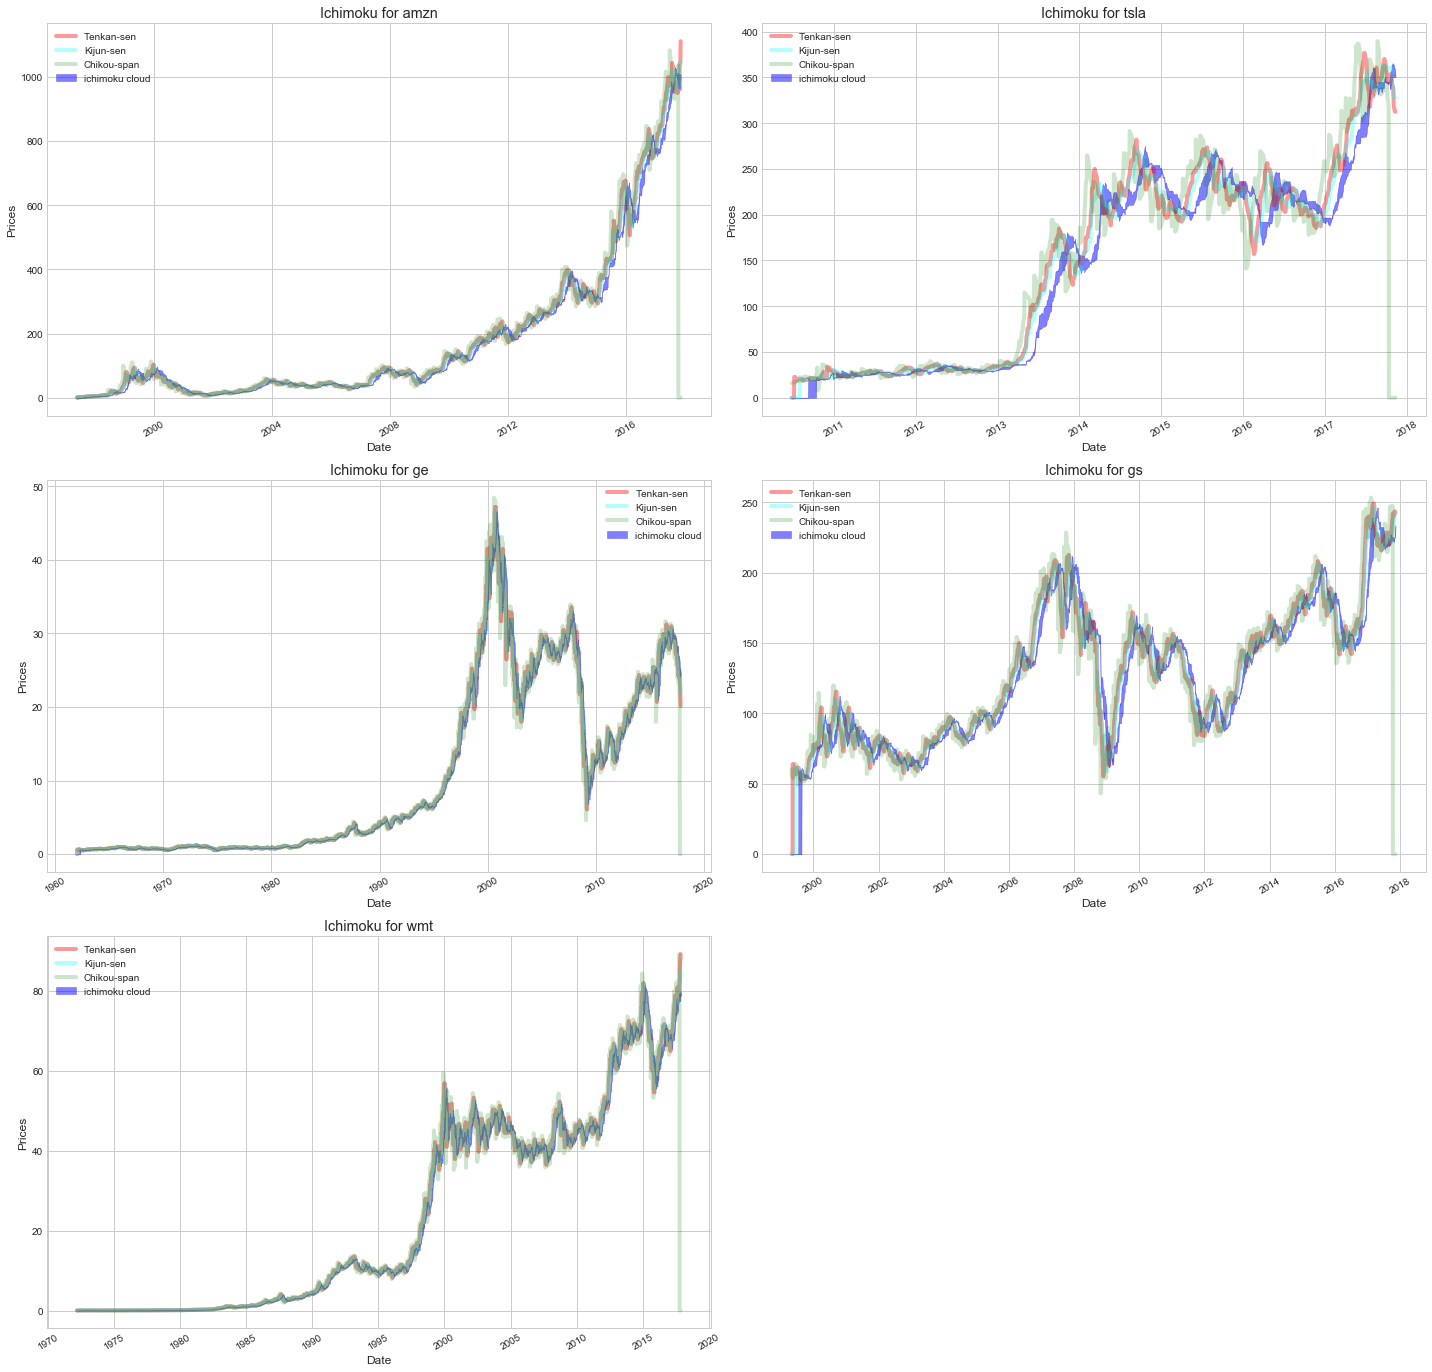

In [69]:
# ichimoku Plots turning_line	standard_line	ichimoku_span1	ichimoku_span2	chikou_span

fig = plt.figure(figsize=(20,25))
for i in range(5):
    ax = plt.subplot(4,2,i+1)
    ax.fill_between(TechIndicator[i].index, TechIndicator[i]['ichimoku_span1'], TechIndicator[i]['ichimoku_span2'], 
                    color='blue', label = "ichimoku cloud", alpha = 0.5)
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(TechIndicator[i].index, TechIndicator[i]['turning_line'], color='red', label = "Tenkan-sen", alpha = 0.4)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['standard_line'], color='cyan', label="Kijun-sen", alpha = 0.3)
    ax.plot(TechIndicator[i].index, TechIndicator[i]['chikou_span'], color='green', label="Chikou-span", alpha = 0.2)
    ax.set_title("Ichimoku for " + str(TechIndicator[i]['Label'][0]))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

I have also tried prediction of movement of stock market based on this data. You can refer to that kernel here: https://www.kaggle.com/kratisaxena/lstm-gru-models-for-stock-movement-analysis